In [1]:
import os
os.chdir('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/graph_var')

from graph_var.graph_var.utils import load_graph_from_pkl
from graph_var.graph_var.graph import PangenomeGraph
from graph_var.graph_var.evaluating_functions import *
import pandas as pd

In [2]:
graph_obj_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Graph_objs'
raw_vcf_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_chr'
graph_vcf_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update'

gfa_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data/chromosome_gfa'
snarl_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data/chr_snarls'
bubble_summary_dir = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Bubble_summary"
bubble_result_dir = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Bubble_result_update"

mode = 'AT'
wavevcf = True

Cleanse table

In [8]:
wavevcf = True

if wavevcf:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave.xlsx'
else:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw.xlsx'

sheet_list = ["repeated_variant_summary", "variant_summary_with_NIA_flag", "variant_region_summary", 
               "snp_region_summary", "snp_ac_range_summary", "snp_ac_range_summary_all", "variant_ourvcf_vs_vcfwave"]

with pd.ExcelFile(file_path) as xls:
    sheets = {sheet: pd.read_excel(xls, sheet) for sheet in xls.sheet_names}

sheets = {k: v for k, v in sheets.items() if k in sheet_list}

if wavevcf:
    file_path_filter = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave_clear.xlsx'
else:
    file_path_filter = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw_clear.xlsx'

with pd.ExcelWriter(file_path_filter, engine="openpyxl") as writer:
    for sheet, df in sheets.items():
        df.to_excel(writer, sheet_name=sheet, index=False)

Part 1: Summary for all variant edges

In [4]:
def variant_edges_summary_from_dict(var_list: list, var_dict: dict):
    summary_dict = dict()
    for edge in sorted(list(var_list)):
        summary_dict[var_dict[edge]] = summary_dict.get(var_dict[edge], 0) + 1
    summary_dict['total'] = len(var_list)
    return summary_dict

def prepare_dataframe_dict(var_dict):
    return pd.DataFrame({
        "Variant Type": ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Inversion', 'Duplication', 'Total'],
        "Count": [
                  var_dict.get('snp', 0),
                  var_dict.get('mnp', 0),
                  var_dict.get('insertion', 0),
                  var_dict.get('deletion', 0),
                  var_dict.get('replacement', 0),
                  var_dict.get('inversion', 0),
                  var_dict.get('duplication', 0),
                  var_dict.get('total', 0),
        ]
    })

In [5]:
for i in range(1, 23):
    graph_vcf_path = f"{graph_vcf_dir}/graph_chr{i}_no_terminus.vcf"
    if wavevcf:
        raw_vcf_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.vcfbub.a100k.wave_chr{i}.vcf"
    else:
        raw_vcf_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.raw_chr{i}.vcf"
    print(f"Processing file: {graph_vcf_path}")
    graph_vcf_df = read_vcf_to_dataframe(graph_vcf_path)

    variants = []

    linear_variants = []
    non_linear_variants = []

    small_variants = []
    large_variants = []

    common_variants = []
    uncommon_variants = []

    linear_small_variants = []
    linear_large_variants = []
    non_linear_small_variants = []
    non_linear_large_variants = []

    linear_common_variants = []
    linear_uncommon_variants = []
    non_linear_common_variants = []
    non_linear_uncommon_variants = []

    small_common_variants = []
    small_uncommon_variants = []
    large_common_variants = []
    large_uncommon_variants = []

    linear_small_common_variants = []
    linear_large_common_variants = []
    linear_small_uncommon_variants = []
    linear_large_uncommon_variants = []

    non_linear_small_common_variants = []
    non_linear_large_common_variants = []
    non_linear_small_uncommon_variants = []
    non_linear_large_uncommon_variants = []

    var_dict = {}

    for k in range(len(graph_vcf_df)):
        row = graph_vcf_df.iloc[k]
        edge = eval(row['ID'])
        info = row['INFO']
        info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in info.split(';') if '=' in attr}
        var_type = info_dict['VT']
        nearly_identical = int(info_dict['NIA'])

        if var_type != 'inversion':
            ref_ac, alt_ac = int(info_dict['RC']), int(info_dict['AC'])
            allele_count = min(ref_ac, alt_ac)
        else:
            alt_ac = int(info_dict['AC'])
            allele_count = alt_ac

        ref_allele = row['REF'] if row['REF'] != '.' else info_dict['OR']
        alt_allele = row['ALT']
        allele_length = len(ref_allele) + len(alt_allele)

        var_dict[edge] = var_type

        on_linear = (int(info_dict['DR'].split(',')[1]) == 0)

        variants.append(edge)

        if on_linear:
            linear_variants.append(edge)
        else:
            non_linear_variants.append(edge)
        
        if allele_length < 50 or nearly_identical:
            small_variants.append(edge)
        else:
            large_variants.append(edge)
        
        if allele_count > 5:
            common_variants.append(edge)
        else:
            uncommon_variants.append(edge)
        
        if on_linear and (allele_length < 50 or nearly_identical):
            linear_small_variants.append(edge)
        elif on_linear and allele_length >= 50:
            linear_large_variants.append(edge)
        elif not on_linear and (allele_length < 50 or nearly_identical):
            non_linear_small_variants.append(edge)
        elif not on_linear and allele_length >= 50:
            non_linear_large_variants.append(edge)
        else:
            raise ValueError("Unexpected case.")
        
        if on_linear and allele_count > 5:
            linear_common_variants.append(edge)
        elif on_linear and allele_count <= 5:
            linear_uncommon_variants.append(edge)
        elif not on_linear and allele_count > 5:
            non_linear_common_variants.append(edge)
        elif not on_linear and allele_count <= 5:
            non_linear_uncommon_variants.append(edge)
        else:
            raise ValueError("Unexpected case.")
        
        if (allele_length < 50 or nearly_identical) and allele_count > 5:
            small_common_variants.append(edge)
        elif (allele_length < 50 or nearly_identical) and allele_count <= 5:
            small_uncommon_variants.append(edge)
        elif allele_length >= 50 and allele_count > 5:
            large_common_variants.append(edge)
        elif allele_length >= 50 and allele_count <= 5:
            large_uncommon_variants.append(edge)
        else:
            raise ValueError("Unexpected case.")

        if on_linear and (allele_length < 50 or nearly_identical) and allele_count > 5:
            linear_small_common_variants.append(edge)
        elif on_linear and allele_length >= 50 and allele_count > 5:
            linear_large_common_variants.append(edge)
        elif on_linear and (allele_length < 50 or nearly_identical) and allele_count <= 5:
            linear_small_uncommon_variants.append(edge)
        elif on_linear and allele_length >= 50 and allele_count <= 5:
            linear_large_uncommon_variants.append(edge)
        elif not on_linear and (allele_length < 50 or nearly_identical) and allele_count > 5:
            non_linear_small_common_variants.append(edge)
        elif not on_linear and allele_length >= 50 and allele_count > 5:
            non_linear_large_common_variants.append(edge)
        elif not on_linear and (allele_length < 50 or nearly_identical) and allele_count <= 5:
            non_linear_small_uncommon_variants.append(edge)
        elif not on_linear and allele_length >= 50 and allele_count <= 5:
            non_linear_large_uncommon_variants.append(edge)
        else:
            raise ValueError("Unexpected case.")
    
    var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(variants, var_dict))

    linear_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_variants, var_dict))
    non_linear_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_variants, var_dict))

    small_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(small_variants, var_dict))
    large_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(large_variants, var_dict))

    common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(common_variants, var_dict))
    uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(uncommon_variants, var_dict))

    linear_small_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_small_variants, var_dict))
    linear_large_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_large_variants, var_dict))
    non_linear_small_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_small_variants, var_dict))
    non_linear_large_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_large_variants, var_dict))

    linear_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_common_variants, var_dict))
    linear_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_uncommon_variants, var_dict))
    non_linear_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_common_variants, var_dict))
    non_linear_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_uncommon_variants, var_dict))

    small_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(small_common_variants, var_dict))
    small_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(small_uncommon_variants, var_dict))
    large_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(large_common_variants, var_dict))
    large_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(large_uncommon_variants, var_dict))

    linear_small_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_small_common_variants, var_dict))
    linear_large_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_large_common_variants, var_dict))
    linear_small_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_small_uncommon_variants, var_dict))
    linear_large_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_large_uncommon_variants, var_dict))

    non_linear_small_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_small_common_variants, var_dict))
    non_linear_large_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_large_common_variants, var_dict))
    non_linear_small_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_small_uncommon_variants, var_dict))
    non_linear_large_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_large_uncommon_variants, var_dict))

    comp_var_summary = pd.DataFrame(
        {
        "CHROM": [f'chr{i}']*len(var_df),

        "Variant Type": var_df['Variant Type'], 
        "All_Variants": var_df['Count'],

        "Linear_Variants": linear_var_df['Count'], 
        "Non_Linear_Variants": non_linear_var_df['Count'], 

        "Small_Variants": small_var_df['Count'], 
        "Large_Variants": large_var_df['Count'], 

        "Common_Variants": common_var_df['Count'], 
        "Uncommon_Variants": uncommon_var_df['Count'], 

        "Linear_Small_Variants": linear_small_var_df['Count'], 
        "Linear_Large_Variants": linear_large_var_df['Count'], 
        "Non_Linear_Small_Variants": non_linear_small_var_df['Count'],  
        "Non_Linear_Large_Variants": non_linear_large_var_df['Count'], 

        "Linear_Common_Variants": linear_common_var_df['Count'], 
        "Linear_Uncommon_Variants": linear_uncommon_var_df['Count'], 
        "Non_Linear_Common_Variants": non_linear_common_var_df['Count'],  
        "Non_Linear_Uncommon_Variants": non_linear_uncommon_var_df['Count'],

        "Small_Common_Variants": small_common_var_df['Count'], 
        "Small_Uncommon_Variants": small_uncommon_var_df['Count'], 
        "Large_Common_Variants": large_common_var_df['Count'],  
        "Large_Uncommon_Variants": large_uncommon_var_df['Count'], 

        "Linear_Small_Common_Variants": linear_small_common_var_df['Count'], 
        "Linear_Large_Common_Variants": linear_large_common_var_df['Count'], 
        "Linear_Small_Uncommon_Variants": linear_small_uncommon_var_df['Count'],  
        "Linear_Large_Uncommon_Variants": linear_large_uncommon_var_df['Count'],

        "Non_Linear_Small_Common_Variants": non_linear_small_common_var_df['Count'], 
        "Non_Linear_Large_Common_Variants": non_linear_large_common_var_df['Count'], 
        "Non_Linear_Small_Uncommon_Variants": non_linear_small_uncommon_var_df['Count'],  
        "Non_Linear_Large_Uncommon_Variants": non_linear_large_uncommon_var_df['Count'], 
        }
    )
    comp_var_summary.to_csv(f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Stats_chr/comprehensive_variant_summary_for_chr{i}.csv", index=False)

Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr1_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr2_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr3_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr4_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr5_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr6_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr7_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr8_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr9_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_upda

In [6]:
import pandas as pd

graph_vcf_summary_df_list = []

for i in range(1, 23):
    graph_vcf_summary_df = pd.read_csv(f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Stats_chr/comprehensive_variant_summary_for_chr{i}.csv")
    graph_vcf_summary_df_list.append(graph_vcf_summary_df)

def sum_up_dfs(df_list, num_id):
    combined = df_list[0].copy()
    for df in df_list[1:]:
        combined.iloc[:, num_id:] += df.iloc[:, num_id:]
    
    return combined

graph_vcf_all_df = sum_up_dfs(graph_vcf_summary_df_list, 2)
graph_vcf_all_df['CHROM'] = 'all'

graph_vcf_summary_df_list.append(graph_vcf_all_df)
graph_vcf_summary_concated_df = pd.concat(graph_vcf_summary_df_list)

In [7]:
if wavevcf:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave.xlsx'
else:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw.xlsx'

sheet_name = "variant_summary_with_NIA_flag"

with pd.ExcelFile(file_path) as xls:
    sheets = {sheet: pd.read_excel(xls, sheet) for sheet in xls.sheet_names}

sheets[sheet_name] = graph_vcf_summary_concated_df

with pd.ExcelWriter(file_path, engine="openpyxl") as writer:
    for sheet, df in sheets.items():
        df.to_excel(writer, sheet_name=sheet, index=False)

/home/shz311/.conda/envs/AIpy310/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Part 1: Hatch-marked for repeated variants

In [4]:
for i in range(1, 23):
    graph_vcf_path = f"{graph_vcf_dir}/graph_chr{i}_no_terminus.vcf"
    if wavevcf:
        raw_vcf_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.vcfbub.a100k.wave_chr{i}.vcf"
    else:
        raw_vcf_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.raw_chr{i}.vcf"
    print(f"Processing file: {graph_vcf_path}")
    graph_vcf_df = read_vcf_to_dataframe(graph_vcf_path)

    variants = []

    linear_variants = []
    non_linear_variants = []

    small_variants = []
    large_variants = []

    common_variants = []
    uncommon_variants = []

    linear_small_variants = []
    linear_large_variants = []
    non_linear_small_variants = []
    non_linear_large_variants = []

    linear_common_variants = []
    linear_uncommon_variants = []
    non_linear_common_variants = []
    non_linear_uncommon_variants = []

    small_common_variants = []
    small_uncommon_variants = []
    large_common_variants = []
    large_uncommon_variants = []

    linear_small_common_variants = []
    linear_large_common_variants = []
    linear_small_uncommon_variants = []
    linear_large_uncommon_variants = []

    non_linear_small_common_variants = []
    non_linear_large_common_variants = []
    non_linear_small_uncommon_variants = []
    non_linear_large_uncommon_variants = []

    var_dict = {}

    for k in range(len(graph_vcf_df)):
        row = graph_vcf_df.iloc[k]
        edge = eval(row['ID'])
        info = row['INFO']
        info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in info.split(';') if '=' in attr}
        var_type = info_dict['VT']
        nearly_identical = int(info_dict['NIA'])

        is_repeat = info_dict['TR_MOTIF'] != '.'

        if is_repeat:
            if var_type != 'inversion':
                ref_ac, alt_ac = int(info_dict['RC']), int(info_dict['AC'])
                allele_count = min(ref_ac, alt_ac)
            else:
                alt_ac = int(info_dict['AC'])
                allele_count = alt_ac

            ref_allele = row['REF'] if row['REF'] != '.' else info_dict['OR']
            alt_allele = row['ALT']
            allele_length = len(ref_allele) + len(alt_allele)

            var_dict[edge] = var_type

            on_linear = (int(info_dict['DR'].split(',')[1]) == 0)

            variants.append(edge)

            if on_linear:
                linear_variants.append(edge)
            else:
                non_linear_variants.append(edge)
            
            if allele_length < 50 or nearly_identical:
                small_variants.append(edge)
            else:
                large_variants.append(edge)
        
            if allele_count > 5:
                common_variants.append(edge)
            else:
                uncommon_variants.append(edge)
            
            if on_linear and (allele_length < 50 or nearly_identical):
                linear_small_variants.append(edge)
            elif on_linear and allele_length >= 50:
                linear_large_variants.append(edge)
            elif not on_linear and (allele_length < 50 or nearly_identical):
                non_linear_small_variants.append(edge)
            elif not on_linear and allele_length >= 50:
                non_linear_large_variants.append(edge)
            else:
                raise ValueError("Unexpected case.")
            
            if on_linear and allele_count > 5:
                linear_common_variants.append(edge)
            elif on_linear and allele_count <= 5:
                linear_uncommon_variants.append(edge)
            elif not on_linear and allele_count > 5:
                non_linear_common_variants.append(edge)
            elif not on_linear and allele_count <= 5:
                non_linear_uncommon_variants.append(edge)
            else:
                raise ValueError("Unexpected case.")
        
            if (allele_length < 50 or nearly_identical) and allele_count > 5:
                small_common_variants.append(edge)
            elif (allele_length < 50 or nearly_identical) and allele_count <= 5:
                small_uncommon_variants.append(edge)
            elif allele_length >= 50 and allele_count > 5:
                large_common_variants.append(edge)
            elif allele_length >= 50 and allele_count <= 5:
                large_uncommon_variants.append(edge)
            else:
                raise ValueError("Unexpected case.")

            if on_linear and (allele_length < 50 or nearly_identical) and allele_count > 5:
                linear_small_common_variants.append(edge)
            elif on_linear and allele_length >= 50 and allele_count > 5:
                linear_large_common_variants.append(edge)
            elif on_linear and (allele_length < 50 or nearly_identical) and allele_count <= 5:
                linear_small_uncommon_variants.append(edge)
            elif on_linear and allele_length >= 50 and allele_count <= 5:
                linear_large_uncommon_variants.append(edge)
            elif not on_linear and (allele_length < 50 or nearly_identical) and allele_count > 5:
                non_linear_small_common_variants.append(edge)
            elif not on_linear and allele_length >= 50 and allele_count > 5:
                non_linear_large_common_variants.append(edge)
            elif not on_linear and (allele_length < 50 or nearly_identical) and allele_count <= 5:
                non_linear_small_uncommon_variants.append(edge)
            elif not on_linear and allele_length >= 50 and allele_count <= 5:
                non_linear_large_uncommon_variants.append(edge)
            else:
                raise ValueError("Unexpected case.")
    
    var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(variants, var_dict))

    linear_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_variants, var_dict))
    non_linear_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_variants, var_dict))

    small_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(small_variants, var_dict))
    large_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(large_variants, var_dict))

    common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(common_variants, var_dict))
    uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(uncommon_variants, var_dict))

    linear_small_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_small_variants, var_dict))
    linear_large_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_large_variants, var_dict))
    non_linear_small_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_small_variants, var_dict))
    non_linear_large_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_large_variants, var_dict))

    linear_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_common_variants, var_dict))
    linear_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_uncommon_variants, var_dict))
    non_linear_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_common_variants, var_dict))
    non_linear_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_uncommon_variants, var_dict))

    small_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(small_common_variants, var_dict))
    small_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(small_uncommon_variants, var_dict))
    large_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(large_common_variants, var_dict))
    large_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(large_uncommon_variants, var_dict))

    linear_small_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_small_common_variants, var_dict))
    linear_large_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_large_common_variants, var_dict))
    linear_small_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_small_uncommon_variants, var_dict))
    linear_large_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_large_uncommon_variants, var_dict))

    non_linear_small_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_small_common_variants, var_dict))
    non_linear_large_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_large_common_variants, var_dict))
    non_linear_small_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_small_uncommon_variants, var_dict))
    non_linear_large_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_large_uncommon_variants, var_dict))

    comp_var_summary = pd.DataFrame(
        {
        "CHROM": [f'chr{i}']*len(var_df),

        "Variant Type": var_df['Variant Type'], 
        "All_Variants": var_df['Count'],

        "Linear_Variants": linear_var_df['Count'], 
        "Non_Linear_Variants": non_linear_var_df['Count'], 

        "Small_Variants": small_var_df['Count'], 
        "Large_Variants": large_var_df['Count'], 

        "Common_Variants": common_var_df['Count'], 
        "Uncommon_Variants": uncommon_var_df['Count'], 

        "Linear_Small_Variants": linear_small_var_df['Count'], 
        "Linear_Large_Variants": linear_large_var_df['Count'], 
        "Non_Linear_Small_Variants": non_linear_small_var_df['Count'],  
        "Non_Linear_Large_Variants": non_linear_large_var_df['Count'], 

        "Linear_Common_Variants": linear_common_var_df['Count'], 
        "Linear_Uncommon_Variants": linear_uncommon_var_df['Count'], 
        "Non_Linear_Common_Variants": non_linear_common_var_df['Count'],  
        "Non_Linear_Uncommon_Variants": non_linear_uncommon_var_df['Count'],

        "Small_Common_Variants": small_common_var_df['Count'], 
        "Small_Uncommon_Variants": small_uncommon_var_df['Count'], 
        "Large_Common_Variants": large_common_var_df['Count'],  
        "Large_Uncommon_Variants": large_uncommon_var_df['Count'], 

        "Linear_Small_Common_Variants": linear_small_common_var_df['Count'], 
        "Linear_Large_Common_Variants": linear_large_common_var_df['Count'], 
        "Linear_Small_Uncommon_Variants": linear_small_uncommon_var_df['Count'],  
        "Linear_Large_Uncommon_Variants": linear_large_uncommon_var_df['Count'],

        "Non_Linear_Small_Common_Variants": non_linear_small_common_var_df['Count'], 
        "Non_Linear_Large_Common_Variants": non_linear_large_common_var_df['Count'], 
        "Non_Linear_Small_Uncommon_Variants": non_linear_small_uncommon_var_df['Count'],  
        "Non_Linear_Large_Uncommon_Variants": non_linear_large_uncommon_var_df['Count'], 
        }
    )
    comp_var_summary.to_csv(f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Stats_chr/comprehensive_repeated_variant_summary_for_chr{i}.csv", index=False)

Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr1_no_terminus.vcf


Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr2_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr3_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr4_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr5_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr6_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr7_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr8_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr9_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/graph_chr10_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_upd

In [5]:
import pandas as pd

graph_vcf_summary_df_list = []

for i in range(1, 23):
    graph_vcf_summary_df = pd.read_csv(f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Stats_chr/comprehensive_repeated_variant_summary_for_chr{i}.csv")
    graph_vcf_summary_df_list.append(graph_vcf_summary_df)

def sum_up_dfs(df_list, num_id):
    combined = df_list[0].copy()
    for df in df_list[1:]:
        combined.iloc[:, num_id:] += df.iloc[:, num_id:]
    
    return combined

graph_vcf_all_df = sum_up_dfs(graph_vcf_summary_df_list, 2)
graph_vcf_all_df['CHROM'] = 'all'

graph_vcf_summary_df_list.append(graph_vcf_all_df)
graph_vcf_summary_concated_df = pd.concat(graph_vcf_summary_df_list)

In [6]:
if wavevcf:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave.xlsx'
else:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw.xlsx'

sheet_name = "repeated_variant_summary"

with pd.ExcelFile(file_path) as xls:
    sheets = {sheet: pd.read_excel(xls, sheet) for sheet in xls.sheet_names}

sheets[sheet_name] = graph_vcf_summary_concated_df

with pd.ExcelWriter(file_path, engine="openpyxl") as writer:
    for sheet, df in sheets.items():
        df.to_excel(writer, sheet_name=sheet, index=False)

/home/shz311/.conda/envs/AIpy310/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Part 2: Summary for variant edges based on different regions

In [10]:
graph_obj_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Graph_objs'
raw_vcf_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_chr'
graph_vcf_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update'
stats_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Stats_update'
ac_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Bubble_result_update'

In [11]:
# other_difficult_bed = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Region_files/GRCh38_subtract_difficult_segdup.bed"
easy_bed = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Region_files/GRCh38_notinalldifficultregions.bed"
segdup_bed = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Region_files/GRCh38_segdups.bed"

In [8]:
df_list = []
for i in range(1,23):
    ac_df_path = f"{ac_dir}/bubble_allele_summary_chr{i}.tsv"
    ac_df = pd.read_csv(ac_df_path, sep='\t')
    df_list.append(ac_df)

allele_count_concated_df = pd.concat(df_list)

In [3]:
def get_df_from_vcf_filtered_by_region(chr_id, raw_vcf=True, graph_vcf=True):
    if wavevcf:
        raw_vcf_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.vcfbub.a100k.wave_{chr_id}.vcf"
    else:
        raw_vcf_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.raw_{chr_id}.vcf"
    graph_vcf_path = f"{graph_vcf_dir}/graph_{chr_id}_no_terminus.vcf"

    easy_region = get_interval_tree_from_bed(easy_bed, chr_id)
    segdup_region = get_interval_tree_from_bed(segdup_bed, chr_id)
    # diff_region = get_interval_tree_from_bed(other_difficult_bed, chr_id)

    if raw_vcf:
        raw_vcf_df = read_vcf_to_dataframe(raw_vcf_path)
        
        def split_vcf_row_minimal(row):
            ACs = row['INFO'].split(';')[0].split('=')[1].split(',')
            alts = row['ALT'].split(',')
            return [{key if key != 'INFO' else 'AC': row[key] if key != 'ALT' and key != 'INFO' else alt if key == 'ALT' else AC \
                for key in row.keys()} for alt, AC in zip(alts, ACs)]

        split_rows = []
        for i in tqdm(range(len(raw_vcf_df))):
            split_rows.extend(split_vcf_row_minimal(raw_vcf_df.iloc[i]))

        split_raw_vcf_df = pd.DataFrame(split_rows)

        split_raw_vcf_df = split_raw_vcf_df[['#CHROM', 'POS', 'REF', 'ALT', 'AC']]

        raw_easy_bool = split_raw_vcf_df['POS'].apply(lambda x: len(easy_region[int(x)]) > 0)
        raw_segdup_bool = split_raw_vcf_df['POS'].apply(lambda x: len(segdup_region[int(x)]) > 0)
        raw_diff_bool = ~raw_easy_bool & ~raw_segdup_bool 

        easy_raw_vcf_df = split_raw_vcf_df[raw_easy_bool]
        segdup_raw_vcf_df = split_raw_vcf_df[raw_segdup_bool]
        diff_raw_vcf_df = split_raw_vcf_df[raw_diff_bool]
    else:
        easy_raw_vcf_df = None
        segdup_raw_vcf_df = None
        diff_raw_vcf_df = None

    if graph_vcf:
        graph_vcf_df = read_vcf_to_dataframe(graph_vcf_path)
        sample_cols = graph_vcf_df.columns[9:]
        def find_type(x):
            info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in x.split(';') if '=' in attr}
            return info_dict['VT']
        graph_vcf_df['Variant_Type'] = graph_vcf_df['INFO'].apply(find_type)
        def if_linear(x):
            info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in x.split(';') if '=' in attr}
            return int(info_dict['DR'].split(',')[1]) == 0
        graph_vcf_df['Linear'] = graph_vcf_df['INFO'].apply(if_linear)
        def find_ac(x):
            info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in x.split(';') if '=' in attr}
            ac = min(int(info_dict['AC']), int(info_dict['RC'])) if info_dict['VT'] != 'inversion' else int(info_dict['AC'])
            return ac
        #graph_vcf_df['AC'] = graph_vcf_df.apply(lambda x: sum([int(AC) for sample in sample_cols for AC in x[sample].split('|')]), axis=1)
        graph_vcf_df['AC'] = graph_vcf_df['INFO'].apply(find_ac)
        simple_graph_vcf_df = graph_vcf_df[['#CHROM', 'POS', 'REF', 'ALT', 'AC', 'Linear', 'Variant_Type']]

        graph_easy_bool = simple_graph_vcf_df['POS'].apply(lambda x: len(easy_region[int(x)]) > 0)
        graph_segdup_bool = simple_graph_vcf_df['POS'].apply(lambda x: len(segdup_region[int(x)]) > 0)
        graph_diff_bool = ~graph_easy_bool & ~graph_segdup_bool

        easy_graph_vcf_df = simple_graph_vcf_df[graph_easy_bool]
        segdup_graph_vcf_df = simple_graph_vcf_df[graph_segdup_bool]
        diff_graph_vcf_df = simple_graph_vcf_df[graph_diff_bool]
    else:
        easy_graph_vcf_df = None
        segdup_graph_vcf_df = None
        diff_graph_vcf_df = None
    
    return {
        "easy_raw": easy_raw_vcf_df,
        "segdup_raw": segdup_raw_vcf_df,
        "diff_raw": diff_raw_vcf_df,
        "easy_graph": easy_graph_vcf_df,
        "segdup_graph": segdup_graph_vcf_df,
        "diff_graph": diff_graph_vcf_df,
    }

def get_df_from_vcf(chr_id, not_in_easy_region=False):
    if wavevcf:
        raw_vcf_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.vcfbub.a100k.wave_{chr_id}.vcf"
    else:
        raw_vcf_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.raw_{chr_id}.vcf"
    graph_vcf_path = f"{graph_vcf_dir}/graph_{chr_id}_no_terminus.vcf"

    raw_vcf_df = read_vcf_to_dataframe(raw_vcf_path)
    graph_vcf_df = read_vcf_to_dataframe(graph_vcf_path)

    if not_in_easy_region:
        easy_region = get_interval_tree_from_bed(easy_bed, chr_id)

    def split_vcf_row_minimal(row):
        ACs = row['INFO'].split(';')[0].split('=')[1].split(',')
        alts = row['ALT'].split(',')
        return [{key if key != 'INFO' else 'AC': row[key] if key != 'ALT' and key != 'INFO' else alt if key == 'ALT' else AC \
            for key in row.keys()} for alt, AC in zip(alts, ACs)]

    split_rows = []
    for i in tqdm(range(len(raw_vcf_df))):
        split_rows.extend(split_vcf_row_minimal(raw_vcf_df.iloc[i]))

    split_raw_vcf_df = pd.DataFrame(split_rows)
    split_raw_vcf_df = split_raw_vcf_df[['#CHROM', 'POS', 'REF', 'ALT', 'AC']]

    if not_in_easy_region:
        split_raw_vcf_df = split_raw_vcf_df[split_raw_vcf_df['POS'].apply(lambda x: len(easy_region[int(x)]) == 0)]

    sample_cols = graph_vcf_df.columns[9:]
    def find_type(x):
        info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in x.split(';') if '=' in attr}
        return info_dict['VT']
    graph_vcf_df['Variant_Type'] = graph_vcf_df['INFO'].apply(find_type)
    def if_linear(x):
        info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in x.split(';') if '=' in attr}
        return int(info_dict['DR'].split(',')[1]) == 0
    graph_vcf_df['Linear'] = graph_vcf_df['INFO'].apply(if_linear)
    def find_ac(x):
        info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in x.split(';') if '=' in attr}
        ac = min(int(info_dict['AC']), int(info_dict['RC'])) if info_dict['VT'] != 'inversion' else int(info_dict['AC'])
        return ac
    #graph_vcf_df['AC'] = graph_vcf_df.apply(lambda x: sum([int(AC) for sample in sample_cols for AC in x[sample].split('|')]), axis=1)
    graph_vcf_df['AC'] = graph_vcf_df['INFO'].apply(find_ac)
    simple_graph_vcf_df = graph_vcf_df[['#CHROM', 'POS', 'REF', 'ALT', 'AC', 'Linear', 'Variant_Type']]

    if not_in_easy_region:
        easy_region = get_interval_tree_from_bed(easy_bed, chr_id)
        simple_graph_vcf_df = simple_graph_vcf_df[simple_graph_vcf_df['POS'].apply(lambda x: len(easy_region[int(x)]) == 0)]

    return simple_graph_vcf_df, split_raw_vcf_df

Region based variant type summary

In [6]:
def region_df_var_summary(region_df):
    summary_dict = dict()
    for i in range(len(region_df)):
        summary_dict[region_df.iloc[i]['Variant_Type']] = summary_dict.get(region_df.iloc[i]['Variant_Type'], 0) + 1
    summary_dict['total'] = len(region_df)
    return summary_dict

def prepare_dataframe_dict(var_dict):
    return pd.DataFrame({
        "Variant Type": ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Inversion', 'Repeat', 'Total'],
        "Count": [
                  var_dict.get('snp', 0),
                  var_dict.get('mnp', 0),
                  var_dict.get('insertion', 0),
                  var_dict.get('deletion', 0),
                  var_dict.get('replacement', 0),
                  var_dict.get('inversion', 0),
                  var_dict.get('repeat', 0),
                  var_dict.get('total', 0),
        ]
    })

In [9]:
easy_list = []
segdup_list = []
diff_list = []

for i in range(1,23):
    print(f"Processing chr{i}...")
    var_dicts = get_df_from_vcf_filtered_by_region(f"chr{i}", raw_vcf=False)

    easy_var_summary = prepare_dataframe_dict(region_df_var_summary(var_dicts['easy_graph']))
    segdup_var_summary = prepare_dataframe_dict(region_df_var_summary(var_dicts['segdup_graph']))
    diff_var_summary = prepare_dataframe_dict(region_df_var_summary(var_dicts['diff_graph']))

    easy_list += easy_var_summary['Count'].to_list()
    segdup_list += segdup_var_summary['Count'].to_list()
    diff_list += diff_var_summary['Count'].to_list()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...


In [10]:
var_region_df = pd.DataFrame({
    'CHROM': [f'chr{int(i/8) + 1}' for i in range(8*22)],
    'Variant_type': ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Inversion', 'Repeat', 'Total']*22,
    'Easy_region': easy_list,
    'Segdup_region': segdup_list,
    'Difficult_region': diff_list,
})

# var_region_df = pd.DataFrame({
#     'CHROM': [f'chr{int(i/8) + 1}' for i in range(8)],
#     'Variant_type': ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Inversion', 'Repeat', 'Total'],
#     'Easy_region': easy_list,
#     'Segdup_region': segdup_list,
#     'Difficult_region': diff_list,
# })

all_df = var_region_df.drop(columns=['CHROM']).groupby('Variant_type', as_index=False).sum()
all_df = all_df.set_index('Variant_type').reindex(['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Inversion', 'Repeat', 'Total']).reset_index()
all_df['CHROM'] = 'all'

var_region_concated_df = pd.concat([var_region_df, all_df])

In [11]:
var_region_concated_df.to_csv('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/variant_summary_by_region_filter_degenerated.csv', index=False)

In [12]:
if wavevcf:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave.xlsx'
else:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw.xlsx'

sheet_name = "variant_region_summary"

with pd.ExcelFile(file_path) as xls:
    sheets = {sheet: pd.read_excel(xls, sheet) for sheet in xls.sheet_names}

sheets[sheet_name] = var_region_concated_df

with pd.ExcelWriter(file_path, engine="openpyxl") as writer:
    for sheet, df in sheets.items():
        df.to_excel(writer, sheet_name=sheet, index=False)

/home/shz311/.conda/envs/AIpy310/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Region based SNP comparison between ourvcf and vcfwave/rawvcf

In [13]:
# simple_count_list = []
complex_count_list = []
nonlinear_count_list = []

shared_count_list = []
our_count_list = []
raw_count_list = []

for i in range(1,23):
    print(f"Processing chr{i}...")
    var_dicts = get_df_from_vcf_filtered_by_region(f"chr{i}")
    def snp_raw(x):
        return len(x['REF']) == 1 and len(x['ALT']) == 1
    def snp_graph(x):
        return x['Variant_Type'] == 'snp'
    snp_dicts = {k:v[v.apply(snp_raw, axis=1)] if k.split('_')[1] == 'raw' else v[v.apply(snp_graph, axis=1)] for k, v in var_dicts.items()}

    easy_linear = snp_dicts['easy_graph'][snp_dicts['easy_graph']['Linear'].apply(lambda x: x == 1)]
    easy_nonlinear = snp_dicts['easy_graph'][snp_dicts['easy_graph']['Linear'].apply(lambda x: x == 0)]
    easy_simple = pd.merge(snp_dicts['easy_graph'], snp_dicts['easy_raw'], how='inner', on=['#CHROM', 'POS', 'REF', 'ALT'])
    
    easy_simple_count = len(easy_simple)
    easy_complex_count = len(easy_linear) - easy_simple_count
    easy_nonlinear_count = len(easy_nonlinear)

    easy_shared_count = len(easy_simple)
    easy_our_count = len(snp_dicts['easy_graph']) - easy_shared_count
    easy_raw_count = len(snp_dicts['easy_raw']) - easy_shared_count

    segdup_linear = snp_dicts['segdup_graph'][snp_dicts['segdup_graph']['Linear'].apply(lambda x: x == 1)]
    segdup_nonlinear = snp_dicts['segdup_graph'][snp_dicts['segdup_graph']['Linear'].apply(lambda x: x == 0)]
    segdup_simple = pd.merge(snp_dicts['segdup_graph'], snp_dicts['segdup_raw'], how='inner', on=['#CHROM', 'POS', 'REF', 'ALT'])
    
    segdup_simple_count = len(segdup_simple)
    segdup_complex_count = len(segdup_linear) - segdup_simple_count
    segdup_nonlinear_count = len(segdup_nonlinear)

    segdup_shared_count = len(segdup_simple)
    segdup_our_count = len(snp_dicts['segdup_graph']) - segdup_shared_count
    segdup_raw_count = len(snp_dicts['segdup_raw']) - segdup_shared_count

    diff_linear = snp_dicts['diff_graph'][snp_dicts['diff_graph']['Linear'].apply(lambda x: x == 1)]
    diff_nonlinear = snp_dicts['diff_graph'][snp_dicts['diff_graph']['Linear'].apply(lambda x: x == 0)]
    diff_simple = pd.merge(snp_dicts['diff_graph'], snp_dicts['diff_raw'], how='inner', on=['#CHROM', 'POS', 'REF', 'ALT'])
    
    diff_simple_count = len(diff_simple)
    diff_complex_count = len(diff_linear) - diff_simple_count
    diff_nonlinear_count = len(diff_nonlinear)

    diff_shared_count = len(diff_simple)
    diff_our_count = len(snp_dicts['diff_graph']) - diff_shared_count
    diff_raw_count = len(snp_dicts['diff_raw']) - diff_shared_count

    # simple_counts = [easy_simple_count, segdup_simple_count, diff_simple_count]
    complex_counts = [easy_complex_count, segdup_complex_count, diff_complex_count]
    nonlinear_counts = [easy_nonlinear_count, segdup_nonlinear_count, diff_nonlinear_count]

    # simple_count_list += simple_counts
    complex_count_list += complex_counts
    nonlinear_count_list += nonlinear_counts

    shared_counts = [easy_shared_count, segdup_shared_count, diff_shared_count]
    our_counts = [easy_our_count, segdup_our_count, diff_our_count]
    raw_counts = [easy_raw_count, segdup_raw_count, diff_raw_count]

    shared_count_list += shared_counts
    our_count_list += our_counts
    raw_count_list += raw_counts

Processing chr1...


100%|██████████| 2147805/2147805 [11:48<00:00, 3033.10it/s]


Processing chr2...


100%|██████████| 2344935/2344935 [12:33<00:00, 3110.62it/s]


Processing chr3...


100%|██████████| 1824338/1824338 [10:07<00:00, 3002.56it/s]


Processing chr4...


100%|██████████| 1883091/1883091 [10:26<00:00, 3006.54it/s]


Processing chr5...


100%|██████████| 1727287/1727287 [09:32<00:00, 3018.25it/s]


Processing chr6...


100%|██████████| 1663396/1663396 [09:18<00:00, 2978.74it/s]


Processing chr7...


100%|██████████| 1625502/1625502 [09:06<00:00, 2971.97it/s]


Processing chr8...


100%|██████████| 1491368/1491368 [08:39<00:00, 2869.86it/s]


Processing chr9...


100%|██████████| 1278156/1278156 [07:25<00:00, 2869.97it/s]


Processing chr10...


100%|██████████| 1359999/1359999 [07:59<00:00, 2837.74it/s]


Processing chr11...


100%|██████████| 1284237/1284237 [07:15<00:00, 2949.26it/s]


Processing chr12...


100%|██████████| 1268873/1268873 [07:30<00:00, 2818.29it/s]


Processing chr13...


100%|██████████| 951606/951606 [05:35<00:00, 2835.95it/s]


Processing chr14...


100%|██████████| 880160/880160 [05:09<00:00, 2840.87it/s]


Processing chr15...


100%|██████████| 845891/845891 [04:58<00:00, 2829.66it/s]


Processing chr16...


100%|██████████| 1006852/1006852 [05:57<00:00, 2816.42it/s]


Processing chr17...


100%|██████████| 837540/837540 [04:57<00:00, 2812.68it/s]


Processing chr18...


100%|██████████| 753013/753013 [04:13<00:00, 2970.44it/s]


Processing chr19...


100%|██████████| 719369/719369 [04:04<00:00, 2941.16it/s]


Processing chr20...


100%|██████████| 639416/639416 [03:38<00:00, 2928.74it/s]


Processing chr21...


100%|██████████| 437230/437230 [02:22<00:00, 3065.60it/s]


Processing chr22...


100%|██████████| 439622/439622 [02:29<00:00, 2949.21it/s]


In [14]:
# region_df = pd.DataFrame({
#     'CHROM': [f'chr{int(i/3) + 1}' for i in range(3*22)],
#     'Region': ['easy', 'segdup', 'difficult']*22,
#     'Simple_var': simple_count_list,
#     'Complex_var': complex_count_list,
#     'Off-linear_var': nonlinear_count_list,
# })

if wavevcf:
    region_df = pd.DataFrame({
    'CHROM': [f'chr{int(i/3) + 1}' for i in range(3*22)],
    'Region': ['easy', 'segdup', 'difficult']*22,
    'Shared': shared_count_list,
    'Ourvcf_only': our_count_list,
    'Vcfwave_only': raw_count_list,
    'Ourvcf_linear': complex_count_list,
    'Ourvcf_offlinear': nonlinear_count_list
})
else:
    region_df = pd.DataFrame({
    'CHROM': [f'chr{int(i/3) + 1}' for i in range(3*22)],
    'Region': ['easy', 'segdup', 'difficult']*22,
    'Shared': shared_count_list,
    'Ourvcf_only': our_count_list,
    'Rawvcf_only': raw_count_list,
    'Ourvcf_linear': complex_count_list,
    'Ourvcf_offlinear': nonlinear_count_list
})

all_df = region_df.drop(columns=['CHROM']).groupby('Region', as_index=False).sum()
all_df = all_df.set_index('Region').reindex(['easy', 'segdup', 'difficult']).reset_index()
all_df['CHROM'] = 'all'

region_concated_df = pd.concat([region_df, all_df])

In [15]:
if wavevcf:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave.xlsx'
else:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw.xlsx'

sheet_name = "snp_region_summary"

with pd.ExcelFile(file_path) as xls:
    sheets = {sheet: pd.read_excel(xls, sheet) for sheet in xls.sheet_names}

sheets[sheet_name] = region_concated_df

with pd.ExcelWriter(file_path, engine="openpyxl") as writer:
    for sheet, df in sheets.items():
        df.to_excel(writer, sheet_name=sheet, index=False)


/home/shz311/.conda/envs/AIpy310/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Variant summary based on allele count

In [4]:
not_in_easy_region=False

In [5]:
simple_count_list = []
complex_count_list = []
nonlinear_count_list = []

def snp_list_by_ac(chr_id):
    graph_vcf, raw_vcf = get_df_from_vcf(chr_id, not_in_easy_region)
    
    graph_vcf = graph_vcf[graph_vcf['Variant_Type'] == 'snp']

    singleton_linear = graph_vcf[(graph_vcf['AC'] == 1) & (graph_vcf['Linear'] == 1)]
    singleton_nonlinear = graph_vcf[(graph_vcf['AC'] == 1) & (graph_vcf['Linear'] == 0)]

    two2four_linear = graph_vcf[(graph_vcf['AC'] >=2) & (graph_vcf['AC'] <=4) & (graph_vcf['Linear'] == 1)]
    two2four_nonlinear = graph_vcf[(graph_vcf['AC'] >=2) & (graph_vcf['AC'] <=4) & (graph_vcf['Linear'] == 0)]

    five2eighteen_linear = graph_vcf[(graph_vcf['AC'] >=5) & (graph_vcf['AC'] <=18) & (graph_vcf['Linear'] == 1)]
    five2eighteen_nonlinear = graph_vcf[(graph_vcf['AC'] >=5) & (graph_vcf['AC'] <=18) & (graph_vcf['Linear'] == 0)]

    above19_linear = graph_vcf[(graph_vcf['AC'] >=19) & (graph_vcf['Linear'] == 1)]
    above19_nonlinear = graph_vcf[(graph_vcf['AC'] >=19) & (graph_vcf['Linear'] == 0)]

    singleton_simple = pd.merge(singleton_linear, raw_vcf, on=['#CHROM', 'POS', 'REF', 'ALT'])
    two2four_simple = pd.merge(two2four_linear, raw_vcf, on=['#CHROM', 'POS', 'REF', 'ALT'])
    five2eighteen_simple = pd.merge(five2eighteen_linear, raw_vcf, on=['#CHROM', 'POS', 'REF', 'ALT'])
    above19_simple = pd.merge(above19_linear, raw_vcf, on=['#CHROM', 'POS', 'REF', 'ALT'])

    singleton_simple_count = len(singleton_simple)
    singleton_complex_count = len(singleton_linear) - singleton_simple_count
    singleton_nonlinear_count = len(singleton_nonlinear)

    two2four_simple_count = len(two2four_simple)
    two2four_complex_count = len(two2four_linear) - two2four_simple_count
    two2four_nonlinear_count = len(two2four_nonlinear)

    five2eighteen_simple_count = len(five2eighteen_simple)
    five2eighteen_complex_count = len(five2eighteen_linear) - five2eighteen_simple_count
    five2eighteen_nonlinear_count = len(five2eighteen_nonlinear)

    above19_simple_count = len(above19_simple)
    above19_complex_count = len(above19_linear) - above19_simple_count
    above19_nonlinear_count = len(above19_nonlinear)

    simple_counts = [singleton_simple_count, two2four_simple_count, five2eighteen_simple_count, above19_simple_count]
    complex_counts = [singleton_complex_count, two2four_complex_count, five2eighteen_complex_count, above19_complex_count]
    nonlinear_counts = [singleton_nonlinear_count, two2four_nonlinear_count, five2eighteen_nonlinear_count, above19_nonlinear_count]

    return simple_counts, complex_counts, nonlinear_counts

for i in range(1,23):
    simple_counts, complex_counts, nonlinear_counts = snp_list_by_ac(f"chr{i}")
    simple_count_list += simple_counts
    complex_count_list += complex_counts
    nonlinear_count_list += nonlinear_counts

100%|██████████| 439622/439622 [01:36<00:00, 4548.78it/s]


In [6]:
range_df = pd.DataFrame({
    'CHROM': [f'chr{int(i/4) + 1}' for i in range(4*22)],
    'Range': ['1', '2-4', '5-18', '19+']*22,
    'Shared': simple_count_list,
    'Ourvcf_linear': complex_count_list,
    'Ourvcf_offlinear': nonlinear_count_list,
})

all_df = range_df.drop(columns=['CHROM']).groupby('Range', as_index=False).sum()
all_df = all_df.set_index('Range').reindex(['1', '2-4', '5-18', '19+']).reset_index()
all_df['CHROM'] = 'all'

range_concated_df = pd.concat([range_df, all_df])

In [7]:
if wavevcf:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave.xlsx'
else:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw.xlsx'

if not_in_easy_region:
    sheet_name = "snp_ac_range_summary_not_easy"
else:
    sheet_name = "snp_ac_range_summary_all"

with pd.ExcelFile(file_path) as xls:
    sheets = {sheet: pd.read_excel(xls, sheet) for sheet in xls.sheet_names}

sheets[sheet_name] = range_concated_df

with pd.ExcelWriter(file_path, engine="openpyxl") as writer:
    for sheet, df in sheets.items():
        df.to_excel(writer, sheet_name=sheet, index=False)

/home/shz311/.conda/envs/AIpy310/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [14]:
if wavevcf:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave.xlsx'
else:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw.xlsx'

with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
    graph_vcf_summary_concated_df.to_excel(writer, sheet_name='variant_summary', index=False)
    #allele_count_concated_df.to_excel(writer, sheet_name='allele_summary', index=False)
    region_concated_df.to_excel(writer, sheet_name='snp_region_summary', index=False)
    range_concated_df.to_excel(writer, sheet_name='range_summary', index=False)

print(f"DataFrames saved to {file_path}")

DataFrames saved to /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw.xlsx


Triallelic/Multiallelic bubble analysis

1. Generating table for mapping bubble id to within variant edges

In [3]:
chr_list = list(range(1,23))
#chr_list = [21]

for chr in chr_list:
    print(f"Processing chr{chr}...")
    #gfa_path = f"{gfa_dir}/chr{chr}.gfa"
    snarl_path = f"{snarl_dir}/chr{chr}.snarls"
    #graph_path = f"{graph_obj_dir}/chr{chr}.pkl"
    graph_vcf_path = f"{graph_vcf_dir}/graph_chr{chr}_no_terminus.vcf"


    write_bubble_summary_result(chr_name=f"chr{chr}",
                                snarl_path=snarl_path,
                                vcf_path=graph_vcf_path,
                                output_dir=bubble_summary_dir
                                )

Processing chr1...
Assigning node to bubbles...


Conducting bubble summary...
Writing bubble summary to CSV...
Processing chr2...
Assigning node to bubbles...
Conducting bubble summary...
Writing bubble summary to CSV...
Processing chr3...
Assigning node to bubbles...
Conducting bubble summary...
Writing bubble summary to CSV...
Processing chr4...
Assigning node to bubbles...
Conducting bubble summary...
Writing bubble summary to CSV...
Processing chr5...
Assigning node to bubbles...
Conducting bubble summary...
Writing bubble summary to CSV...
Processing chr6...
Assigning node to bubbles...
Conducting bubble summary...
Writing bubble summary to CSV...
Processing chr7...
Assigning node to bubbles...
Conducting bubble summary...
Writing bubble summary to CSV...
Processing chr8...
Assigning node to bubbles...
Conducting bubble summary...
Writing bubble summary to CSV...
Processing chr9...
Assigning node to bubbles...
Conducting bubble summary...
Writing bubble summary to CSV...
Processing chr10...
Assigning node to bubbles...
Conductin

2. Generating table for mapping number of variants to number of alleles

In [8]:
chr_list = list(range(1,23))
#chr_list = [21]

for chr in chr_list:
    print(f"Processing chr{chr}...")
    summary_path = f"{bubble_summary_dir}/bubble_variant_counts_chr{chr}_AT.tsv"
    #graph_path = f"{graph_obj_dir}/chr{chr}.pkl"
    vcf_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.raw_chr{chr}.vcf"
    vcfwave_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.vcfbub.a100k.wave_chr{chr}.vcf"

    AT_csv = pd.read_csv(summary_path, sep='\t')
    bubble_ids = AT_csv['Bubble_ids'].apply(lambda x: tuple(map(lambda y: y, eval(x))))
    bubble_vars = AT_csv['Within'].apply(lambda x: list(map(lambda y: y, eval(x))))
    AT_bubble_level_dict = {tuple(sorted(bubble)): int(level) for bubble, level in zip(bubble_ids, AT_csv['Level'])}
    AT_allele_count_dict = {tuple(sorted(bubble)): len(var) for bubble, var in zip(bubble_ids, bubble_vars)}

    vcf_csv = read_vcf_to_dataframe(vcf_path)
    vcf_allele_count_dict = {tuple(sorted(extract_bubble_ids(vcf_csv['ID'].iloc[i]))): len(vcf_csv['ALT'].iloc[i].split(',')) for i in range(len(vcf_csv))}
    #G, walks, walk_sample_names = load_graph_from_pkl(graph_path, compressed=False)

    vcfwave_csv = read_vcf_to_dataframe(vcfwave_path)
    vcfwave_allele_count_dict = vcfwave_csv['ID'].apply(lambda x: tuple(sorted(extract_bubble_ids(x.split('_')[0])))).value_counts().to_dict()

    bubble_allelic_records = [{'Bubble_id':bubble, 
                               'Level':AT_bubble_level_dict[bubble], 
                               'num_variants':AT_allele_count_dict[bubble], 
                               'raw_vcf_allele_count': vcf_allele_count_dict.get(bubble, '.'), 
                               'vcfwave_allele_count':vcfwave_allele_count_dict.get(bubble, '.')} 
                               for bubble in AT_allele_count_dict.keys()]
    bubble_allelic_df = pd.DataFrame(bubble_allelic_records)
    bubble_allelic_df = bubble_allelic_df.sort_values(by='Bubble_id')
    bubble_allelic_df.to_csv(f"{bubble_summary_dir}/bubble_allele_summary_chr{chr}.tsv", sep='\t')

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...


In [ ]:
df_list = []
for i in range(1,23):
    ac_df_path = f"{bubble_summary_dir}/bubble_allele_summary_chr{i}.tsv"
    ac_df = pd.read_csv(ac_df_path, sep='\t')
    df_list.append(ac_df)

concated_df = pd.concat(df_list)
concated_df.to_csv(f"{bubble_summary_dir}/bubble_allele_summary_all_chr.tsv", index=False, sep='\t')

3. Generating table for extracting triallelic variants

In [3]:
triallelic_var_dfs = [] 

for i in range(1,23):
    print(f"Processing chr{i}...")
    graph_vcf_path = f"{graph_vcf_dir}/graph_chr{i}_no_terminus.vcf"
    graph_vcf_df = read_vcf_to_dataframe(graph_vcf_path)

    bubble_summary_path = f"{bubble_summary_dir}/bubble_variant_counts_chr{i}_AT.tsv"
    bubble_summary_df = pd.read_csv(bubble_summary_path, sep = '\t')

    triallelic_vars = {var for j in range(len(bubble_summary_df)) 
                       if int(bubble_summary_df.loc[j, 'Level']) == 0 and len(eval(bubble_summary_df.loc[j, 'Within'])) == 2 
                       for var in eval(bubble_summary_df.loc[j, 'Within'])}
    triallelic_var_df = graph_vcf_df[graph_vcf_df['ID'].apply(lambda x: extract_bubble_ids(x, symbol=True)).isin(triallelic_vars)]

    triallelic_var_df.to_csv(f"{bubble_summary_dir}/triallelic_variants_chr{i}.tsv", sep='\t')

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...


In [6]:
triallelic_var_summary = {}

for i in range(1,23):
    triallelic_var_path = f"{bubble_summary_dir}/triallelic_variants_chr{i}.tsv"
    triallelic_var_df = pd.read_csv(triallelic_var_path, sep='\t')
    for j in range(len(triallelic_var_df)):
        info_dict = get_info_dict(triallelic_var_df.loc[j, 'INFO'])
        VT = info_dict['VT']
        triallelic_var_summary[VT] = triallelic_var_summary.get(VT, 0) + 1

print(triallelic_var_summary)
print(sum(triallelic_var_summary.values()))

{'deletion': 356663, 'insertion': 392492, 'snp': 726627, 'mnp': 53508, 'replacement': 17726}
1547016


4. Categorize triallelic bubbles

In [3]:
for i in range(1, 23):
    print(f"Processing chr{i}")
    AT_csv = pd.read_csv(f"{bubble_summary_dir}/bubble_variant_counts_chr{i}_AT.tsv", sep='\t')
    G, walks, walk_sample_names = load_graph_from_pkl(f"{graph_obj_dir}/chr{i}.pkl", compressed=False)

    bubble_candidate = AT_csv.apply(lambda x: len(eval(x['Within'])) == 2 and int(x['Level']) == 0, axis=1)

    bubble_ids = AT_csv['Bubble_ids'][bubble_candidate].apply(lambda x: tuple(map(lambda y: y, eval(x))))
    bubble_vars = AT_csv['Within'][bubble_candidate].apply(lambda x: list(map(lambda y: y, eval(x))))

    bubble_var_dict = dict(zip(bubble_ids, bubble_vars))

    failed_bubble = []
    error_dict = defaultdict(list)
    bubble_type_dict = {}

    for bubble, bubble_var in zip(bubble_ids, bubble_vars):
        try:
            bubble_type_dict[bubble] = G.classify_triallelic_bubble([bubble[0], bubble[1]], bubble_var)
        except Exception as e:
            failed_bubble.append(bubble)
            error_dict['Error'].append(e)
            error_dict['Bubble'].append(bubble)
    print(len(bubble_ids), len(failed_bubble))
    print(failed_bubble[:10])
    
    bubble_triallelic_df = pd.DataFrame({'Bubble': list(bubble_type_dict.keys()), 'Bubble_type': list(bubble_type_dict.values())})
    bubble_triallelic_df.to_csv(f"{bubble_summary_dir}/bubble_triallelic_chr{i}.tsv", sep='\t')

Processing chr1


62139 0
[]
Processing chr2
66112 0
[]
Processing chr3
51494 0
[]
Processing chr4
52335 0
[]
Processing chr5
47846 0
[]
Processing chr6
48674 0
[]
Processing chr7
46378 0
[]
Processing chr8
39644 0
[]
Processing chr9
32954 0
[]
Processing chr10
36287 0
[]
Processing chr11
36912 0
[]
Processing chr12
37086 0
[]
Processing chr13
26313 0
[]
Processing chr14
23835 0
[]
Processing chr15
22828 0
[]
Processing chr16
26907 0
[]
Processing chr17
25875 0
[]
Processing chr18
21269 0
[]
Processing chr19
24499 0
[]
Processing chr20
18420 0
[]
Processing chr21
12958 0
[]
Processing chr22
12743 0
[]


In [ ]:
df_list = []
for i in range(1,23):
    triallelic_df_path = f"{bubble_summary_dir}/bubble_triallelic_chr{i}.tsv"
    triallelic_df = pd.read_csv(triallelic_df_path, sep='\t')
    df_list.append(triallelic_df)

concated_df = pd.concat(df_list)
concated_df.to_csv(f"{bubble_summary_dir}/bubble_triallelic_all_chr.tsv", index=False, sep='\t')

In [73]:
# triallelic_type_df = pd.read_csv(f"{bubble_result_dir}/bubble_triallelic_chr22.tsv", sep='\t')

# bubble_summary_path = f"{bubble_summary_dir}/bubble_variant_counts_chr22_AT.tsv"
# bubble_summary_df = pd.read_csv(bubble_summary_path, sep = '\t')

# multiallelic_df = bubble_summary_df[bubble_summary_df['Within_count'] == 2]
# bubble_col = 'Bubble_ids'

# node_to_bubble = {str(edge): bubble_id for bubble_id, edges in zip(multiallelic_df[bubble_col], multiallelic_df['Within']) for edge in eval(edges)}
# bubble_to_type = {bubble_id: bubble_type for bubble_id, bubble_type in zip(triallelic_type_df['Bubble'], triallelic_type_df['Bubble_type'])}

# chr22_our_vcf = read_vcf_to_dataframe(f"{graph_vcf_dir}/graph_chr22_no_terminus.vcf")
# chr22_vcfwave = read_vcf_to_dataframe(f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.vcfbub.a100k.wave_chr22.vcf")

# chr22_our_vcf['Bubble'] = chr22_our_vcf['ID'].apply(lambda x: node_to_bubble.get(x, 'Others'))
# chr22_vcfwave['Bubble'] = chr22_vcfwave['ID'].apply(lambda x: str(extract_bubble_ids(x)))

# chr22_our_vcf_bubble_alt_len = chr22_our_vcf.groupby('Bubble')['ALT'].agg(lambda x: x.apply(len).sum()).reset_index()
# chr22_vcfwave_bubble_alt_len = chr22_vcfwave.groupby('Bubble')['ALT'].agg(lambda x: x.apply(len).sum()).reset_index()

# ourvcf_vcfwave_alt_len_comparison = chr22_our_vcf_bubble_alt_len.merge(chr22_vcfwave_bubble_alt_len, on=['Bubble'], how='inner', suffixes=('_our', '_wave'))
# ourvcf_vcfwave_alt_len_comparison['Bubble_type'] = ourvcf_vcfwave_alt_len_comparison['Bubble'].apply(lambda x: bubble_to_type[x])

# ourvcf_vcfwave_alt_len_comparison.to_csv(f"{bubble_summary_dir}/bubble_our_wave_vcf_alt_len_comparison_chr22.tsv", sep='\t', index=False)

Large superbubbles (50 or 1000 bps threshold), summarise variants separated by whether GRCh38 or not.

In [3]:
GRCh38 = []
Non_GRCh38 = []

for i in range(1,23):
    print(f"Processing chr{i}...")
    graph_vcf_path = f"{graph_vcf_dir}/graph_chr{i}_no_terminus.vcf"
    bubble_AT_path = f"{bubble_summary_dir}/bubble_variant_counts_chr{i}_AT.tsv"

    graph_vcf_df = read_vcf_to_dataframe(graph_vcf_path)
    bubble_AT_df = pd.read_csv(bubble_AT_path, sep='\t')

    var_len_dict = {}

    for k in range(len(graph_vcf_df)):
        row = graph_vcf_df.iloc[k]
        edge = eval(row['ID'])
        info = row['INFO']
        info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in info.split(';') if '=' in attr}

        ref_allele = row['REF'] if row['REF'] != '.' else info_dict['OR']
        alt_allele = row['ALT']
        allele_length = len(ref_allele) + len(alt_allele)

        var_len_dict[edge] = allele_length
    
    def filter_large_bubble(x, threshold=50):
        var_set = eval(x)
        total_len = sum([var_len_dict[var] for var in var_set])
        return total_len >= threshold
    
    bubble_AT_df_large = bubble_AT_df[bubble_AT_df['Within'].apply(lambda x: filter_large_bubble(x, 50))]
    large_bubble_var_set = {var for vset in bubble_AT_df_large['Within'] for var in eval(vset)}

    graph_vcf_df_large_bubble = graph_vcf_df[graph_vcf_df['ID'].apply(lambda x: eval(x) in large_bubble_var_set)]

    def on_linear(x):
        info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in x.split(';') if '=' in attr}
        return (int(info_dict['DR'].split(',')[1]) == 0)

    GRCh38_count = graph_vcf_df_large_bubble['INFO'].apply(on_linear).sum()
    NonGRCh38_count = len(graph_vcf_df_large_bubble) - GRCh38_count

    GRCh38.append(GRCh38_count)
    Non_GRCh38.append(NonGRCh38_count)

large_bubble_variant_whether_linear_df = pd.DataFrame({
    'CHROM': list(range(1,23)),
    'GRCh38 count': GRCh38,
    'Non-GRCh38 count': Non_GRCh38
})

large_bubble_variant_whether_linear_df.to_csv(f"{bubble_summary_dir}/large_bubble_variant_50bp_whether_linear.csv", index=False)

Processing chr1...


Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...


In [3]:
GRCh38 = []
Non_GRCh38 = []

for i in range(1,23):
    print(f"Processing chr{i}...")
    graph_vcf_path = f"{graph_vcf_dir}/graph_chr{i}_no_terminus.vcf"
    bubble_AT_path = f"{bubble_summary_dir}/bubble_variant_counts_chr{i}_AT.tsv"

    graph_vcf_df = read_vcf_to_dataframe(graph_vcf_path)
    bubble_AT_df = pd.read_csv(bubble_AT_path, sep='\t')

    var_len_dict = {}

    for k in range(len(graph_vcf_df)):
        row = graph_vcf_df.iloc[k]
        edge = eval(row['ID'])
        info = row['INFO']
        info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in info.split(';') if '=' in attr}

        ref_allele = row['REF'] if row['REF'] != '.' else info_dict['OR']
        alt_allele = row['ALT']
        allele_length = len(ref_allele) + len(alt_allele)

        var_len_dict[edge] = allele_length
    
    def filter_large_bubble(x, threshold=50):
        var_set = eval(x)
        total_len = sum([var_len_dict[var] for var in var_set])
        return total_len >= threshold
    
    bubble_AT_df_large = bubble_AT_df[bubble_AT_df['Within'].apply(lambda x: filter_large_bubble(x, 1000))]
    large_bubble_var_set = {var for vset in bubble_AT_df_large['Within'] for var in eval(vset)}

    graph_vcf_df_large_bubble = graph_vcf_df[graph_vcf_df['ID'].apply(lambda x: eval(x) in large_bubble_var_set)]

    def on_linear(x):
        info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in x.split(';') if '=' in attr}
        return (int(info_dict['DR'].split(',')[1]) == 0)

    GRCh38_count = graph_vcf_df_large_bubble['INFO'].apply(on_linear).sum()
    NonGRCh38_count = len(graph_vcf_df_large_bubble) - GRCh38_count

    GRCh38.append(GRCh38_count)
    Non_GRCh38.append(NonGRCh38_count)

large_bubble_variant_whether_linear_df = pd.DataFrame({
    'CHROM': list(range(1,23)),
    'GRCh38 count': GRCh38,
    'Non-GRCh38 count': Non_GRCh38
})

large_bubble_variant_whether_linear_df.to_csv(f"{bubble_summary_dir}/large_bubble_variant_1kbp_whether_linear.csv", index=False)

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...


Analysis: Triallelic-superbubble variants

Chart: Variants by type and whether in vcfwave

In [2]:
# categories_ = ['snp', 'mnp', 'insertion', 'deletion', 'replacement']
# categories = ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement']

categories_ = ['snp']
categories = ['SNP']

our_list = []
shared_list = []
wave_list = []

# def is_var_type(x, var_type):
#     VT = identify_variant_type_from_ref_alt(x['REF'], x['ALT'])
#     return VT == var_type

def is_snp(x):
    return len(x['REF']) == len(x['ALT']) == 1


for i in range(1,23):
    print(f"Processing chr{i}...")
    graph_vcf_path = f"{graph_vcf_dir}/graph_chr{i}_no_terminus.vcf"
    vcf_wave_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.vcfbub.a100k.wave_chr{i}.vcf"

    graph_vcf_df = read_vcf_to_dataframe(graph_vcf_path)[['POS', 'REF', 'ALT', 'INFO']]
    vcf_wave_df = read_vcf_to_dataframe(vcf_wave_path)[['POS', 'REF', 'ALT', 'INFO']]

    for category in categories_:
        graph_vcf_df_temp = graph_vcf_df[graph_vcf_df.apply(lambda x: get_info_dict(x['INFO'])['VT'] == 'snp', axis=1)]
        vcf_wave_df_temp = vcf_wave_df[vcf_wave_df.apply(lambda x: is_snp(x), axis=1)]
        shared_with_vcfwave = graph_vcf_df_temp.merge(vcf_wave_df_temp, how='inner', on=['POS', 'REF', 'ALT'])
        count_our_vcf = len(graph_vcf_df_temp) - len(shared_with_vcfwave)
        count_vcfwave = len(vcf_wave_df_temp) - len(shared_with_vcfwave)
        count_shared = len(shared_with_vcfwave)
        our_list.append(count_our_vcf)
        shared_list.append(count_shared)
        wave_list.append(count_vcfwave)

Processing chr1...


Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...


In [5]:
variant_type_df = pd.DataFrame({
    'CHROM': [f'chr{int(i/1) + 1}' for i in range(1*22)],
    'Variant_type': categories*22,
    'Shared': shared_list,
    'Ourvcf_only': our_list,
    'Vcfwave_only': wave_list
})

all_df = variant_type_df.drop(columns=['CHROM']).groupby('Variant_type', as_index=False).sum()
all_df = all_df.set_index('Variant_type').reindex(categories).reset_index()
all_df['CHROM'] = 'all'

variant_type_concated_df = pd.concat([variant_type_df, all_df])

In [9]:
file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave.xlsx'

sheet_name = 'variant_ourvcf_vs_vcfwave'

try:
    with pd.ExcelWriter(file_path, mode="a", engine="openpyxl", if_sheet_exists="new") as writer:
        variant_type_concated_df.to_excel(writer, sheet_name=sheet_name, index=False)
except FileNotFoundError:
    with pd.ExcelWriter(file_path, mode="w", engine="openpyxl") as writer:
        variant_type_concated_df.to_excel(writer, sheet_name=sheet_name, index=False)

/home/shz311/.conda/envs/AIpy310/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Visualization

In [1]:
import os
os.chdir('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/graph_var')

from graph_var.graph_var.utils import load_graph_from_pkl
from graph_var.graph_var.graph import PangenomeGraph
from graph_var.graph_var.evaluating_functions import *
import pandas as pd

graph_obj_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Graph_objs'
raw_vcf_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_chr'
graph_vcf_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update'

gfa_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data/chromosome_gfa'
snarl_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data/chr_snarls'
bubble_summary_dir = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Bubble_summary"

mode = 'AT'
wavevcf = True

In [2]:
import pandas as pd

file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave_clear.xlsx'

sheets = pd.read_excel(file_path, sheet_name=None)

variant_type_concated_df = sheets['variant_ourvcf_vs_vcfwave']
variant_type_df = variant_type_concated_df[variant_type_concated_df['CHROM'] == 'all']

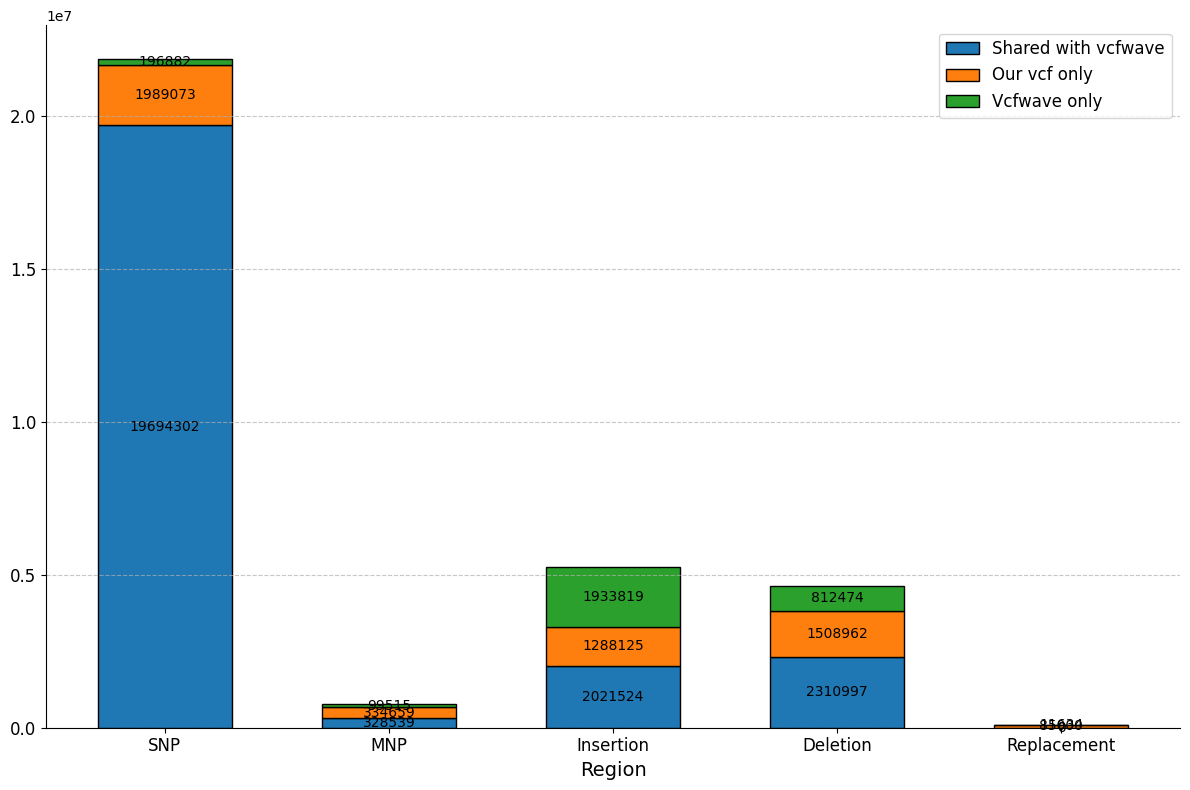

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the stacked bar chart
categories = ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement']
data_stack1 = list(variant_type_df['shared'])  # Values for the first stack
data_stack2 = list(variant_type_df['our vcf only'])  # Values for the second stack
data_stack3 = list(variant_type_df['vcfwave only'])  # Values for the third stack

# Define bar positions and width
x = np.arange(len(categories))  # X positions for the bars
bar_width = 0.6

# Create the figure and axis
plt.figure(figsize=(12, 8))

# Create the stacked bars
plt.bar(x, data_stack1, width=bar_width, label='Shared with vcfwave', edgecolor='black')
plt.bar(x, data_stack2, width=bar_width, bottom=data_stack1, label='Our vcf only', edgecolor='black')
plt.bar(x, data_stack3, width=bar_width, bottom=np.array(data_stack1) + np.array(data_stack2), label='Vcfwave only', edgecolor='black')

# Annotate values on each stack
for i, value in enumerate(data_stack1):
    plt.text(x[i], value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 1
for i, value in enumerate(data_stack2):
    bottom_value = data_stack1[i]
    plt.text(x[i], bottom_value + value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 2
for i, value in enumerate(data_stack3):
    bottom_value = data_stack1[i] + data_stack2[i]
    plt.text(x[i], bottom_value + value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 3


# Add titles and labels
# plt.xlabel('Region', fontsize=14)
# plt.ylabel('Count', fontsize=14)
plt.xticks(x, categories, fontsize=12)
plt.yticks(fontsize=12)

# Add a legend
plt.legend(fontsize=12, title_fontsize=14, loc='upper right')

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize the axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/stacked_bar_chart_variant_type_vcfwave.pdf', dpi=600, bbox_inches='tight', format='pdf')

# Show the plot
plt.show()



Chart: Variants in triallelic bubbles by type and whether in vcfwave

In [5]:
categories_ = ['snp', 'mnp', 'insertion', 'deletion', 'replacement', 'inversion', 'repeat', 'inversion_repeat']
categories = ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Inversion', 'Repeat', 'Inversion&Repeat']
data = {
    'Category': categories,
    'our vcf': [0]*8,
    'shared with vcfwave': [0]*8
}

def is_var_type(x, var_type):
    info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in x.split(';') if '=' in attr}
    return info_dict['VT'] == var_type


for i in range(1,23):
    print(f"Processing chr{i}...")
    vcf_wave_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.vcfbub.a100k.wave_chr{i}.vcf"
    triallelic_var_path = f"{bubble_summary_dir}/triallelic_variants_chr{i}.tsv"

    vcf_wave_df = read_vcf_to_dataframe(vcf_wave_path)[['POS', 'REF', 'ALT', 'INFO']]
    triallelic_df = pd.read_csv(triallelic_var_path, sep='\t', dtype=str)[['POS', 'REF', 'ALT', 'INFO']]

    for category in categories_:
        triallelic_df_temp = triallelic_df[triallelic_df['INFO'].apply(lambda x: is_var_type(x, category))]
        shared_with_vcfwave = triallelic_df_temp.merge(vcf_wave_df, how='inner', on=['POS', 'REF', 'ALT'])
        count_our_vcf = len(triallelic_df_temp) - len(shared_with_vcfwave)
        count_shared = len(shared_with_vcfwave)
        data['our vcf'][categories_.index(category)] += count_our_vcf
        data['shared with vcfwave'][categories_.index(category)] += count_shared

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...


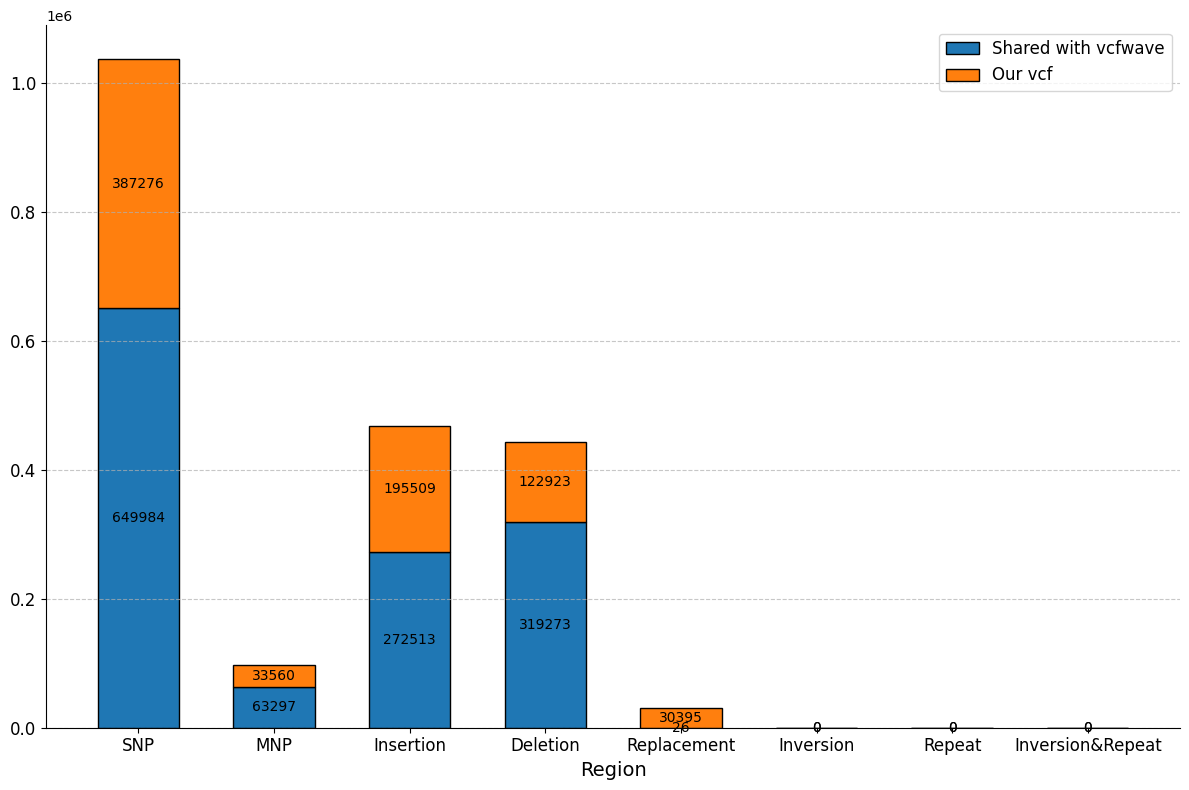

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the stacked bar chart
categories = ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Inversion', 'Repeat', 'Inversion&Repeat']
data_stack1 = data['shared with vcfwave']  # Values for the first stack
data_stack2 = data['our vcf']  # Values for the second stack

# Define bar positions and width
x = np.arange(len(categories))  # X positions for the bars
bar_width = 0.6

# Create the figure and axis
plt.figure(figsize=(12, 8))

# Create the stacked bars
plt.bar(x, data_stack1, width=bar_width, label='Shared with vcfwave', edgecolor='black')
plt.bar(x, data_stack2, width=bar_width, bottom=data_stack1, label='Our vcf', edgecolor='black')

# Annotate values on each stack
# for i, value in enumerate(data_stack1):
#     plt.text(x[i], value / 2, str(value), ha='center', va='center', fontsize=10, color='black')
# for i, value in enumerate(data_stack2):
#     bottom_value = data_stack1[i]
#     plt.text(x[i], bottom_value + value / 2, str(value), ha='center', va='center', fontsize=10, color='black')


# Add titles and labels
plt.xlabel('Region', fontsize=14)
# plt.ylabel('Count', fontsize=14)
plt.xticks(x, categories, fontsize=12)
plt.yticks(fontsize=12)

# Add a legend
plt.legend(fontsize=12, title_fontsize=14, loc='upper right')

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize the axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/triallelic_stacked_bar_chart_variant_type_vcfwave.pdf', dpi=600, bbox_inches='tight', format='pdf')

# Show the plot
plt.show()



In [3]:
import pandas as pd

wavevcf = True

if wavevcf:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave_clear.xlsx'
else:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw.xlsx'

sheets = pd.read_excel(file_path, sheet_name=None)

In [4]:
graph_vcf_summary_concated_df = sheets['variant_summary_with_NIA_flag']
repeated_var_summary_concated_df = sheets['repeated_variant_summary']
region_concated_df = sheets['snp_region_summary']
range_concated_df = sheets['snp_ac_range_summary']

In [5]:
graph_vcf_summary_df = graph_vcf_summary_concated_df[graph_vcf_summary_concated_df['CHROM'] == 'all']
repeated_var_summary_df = repeated_var_summary_concated_df[repeated_var_summary_concated_df['CHROM'] == 'all']
region_df = region_concated_df[region_concated_df['CHROM'] == 'all']
range_df = range_concated_df[range_concated_df['CHROM'] == 'all']

Chart 1a: Small/Large Variant Bar

In [6]:
# Define warm colors
colors = {
    "primary": "#0343DF",
    "hatch": "black"
}

/tmp/ipykernel_5122/226637.py:8: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

/tmp/ipykernel_5122/226637.py:9: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

/tmp/ipykernel_5122/226637.py:10: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

/tmp/ipykernel_5122/226637.py:11: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

/tmp/ipykernel_5122/226637.py:12: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

/tmp/ipykernel_5122/226637.py:13: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeErr

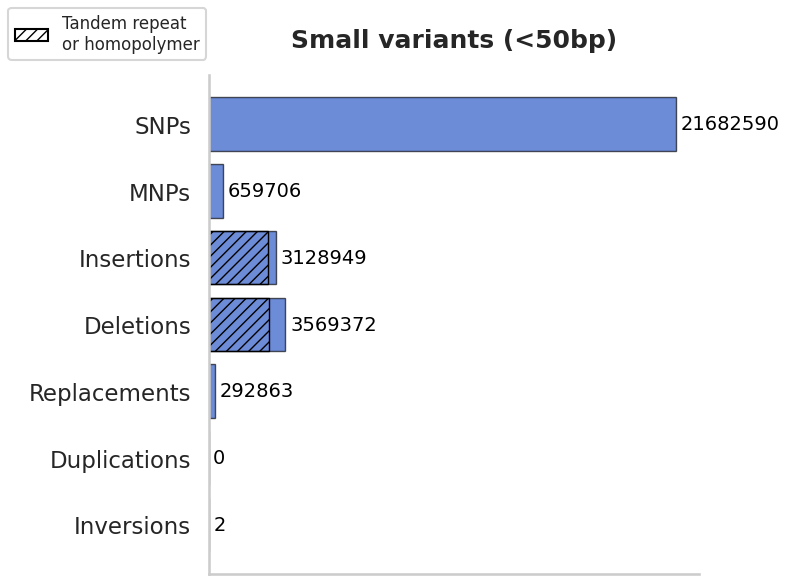

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import matplotlib.patches as mpatches

categories = ['SNPs', 'MNPs', 'Insertions', 'Deletions', 'Replacements', 'Duplications', 'Inversions']
values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Small_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Small_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Small_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Deletion']['Small_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Replacement']['Small_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Duplication']['Small_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Inversion']['Small_Variants'])]

repeat_values = [int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'SNP']['Small_Variants']), 
          int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'MNP']['Small_Variants']), 
          int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'Insertion']['Small_Variants']), 
          int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'Deletion']['Small_Variants']), 
          int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'Replacement']['Small_Variants']),
          int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'Duplication']['Small_Variants']),
          int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'Inversion']['Small_Variants'])]

# Data Preparation
data = pd.DataFrame({'Category': categories, 'Count': values, 'Repeat Count': repeat_values})

# Seaborn Theme
sns.set_theme(style="whitegrid", palette="muted", context="talk")

# Define max count for offset calculation
max_count = data['Count'].max()
offset = 0.01 * max_count

# Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot Normal Bars
bars = sns.barplot(y='Category', x='Count', data=data, linewidth=1, edgecolor='black', color=colors['primary'], alpha=0.65)

# Add hatched bars for repeated values
for i, (total_value, repeated_value) in enumerate(zip(data['Count'], data['Repeat Count'])):
    if repeated_value > 0:  # Ensure non-zero repeated values
        ax.barh(y=i, width=repeated_value, color="none", edgecolor=colors["hatch"], hatch="///", linewidth=1)

# Set Titles and Labels
plt.title('Small variants (<50bp)', fontsize=18, weight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')

# Format X-axis (scientific notation)
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
ax.set_xticklabels([])
ax.grid(False)

# **Add Custom Legend**
legend_handles = [
    mpatches.Patch(facecolor="none", edgecolor="black", hatch="///", label=f"Tandem repeat\nor homopolymer")  # Hatched part
]

fig.legend(handles=legend_handles, loc="upper left", fontsize=12)

# Remove Spines for Clean Look
sns.despine(left=False, bottom=False)

# Add value labels next to bars
for i, v in enumerate(data['Count']):
    plt.text(v + offset, i, f"{v}", va='center', fontsize=14, color='black')

# Show the plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/small_variant_bar_chart_all_chr.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/small_variant_bar_chart_all_chr.png', dpi=600, bbox_inches='tight', format='png')

plt.show()


/tmp/ipykernel_23586/1817718673.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Large_Variants']),
/tmp/ipykernel_23586/1817718673.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Large_Variants']),
/tmp/ipykernel_23586/1817718673.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Large_Variants']),
/tmp/ipykernel_23586/1817718673.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) i

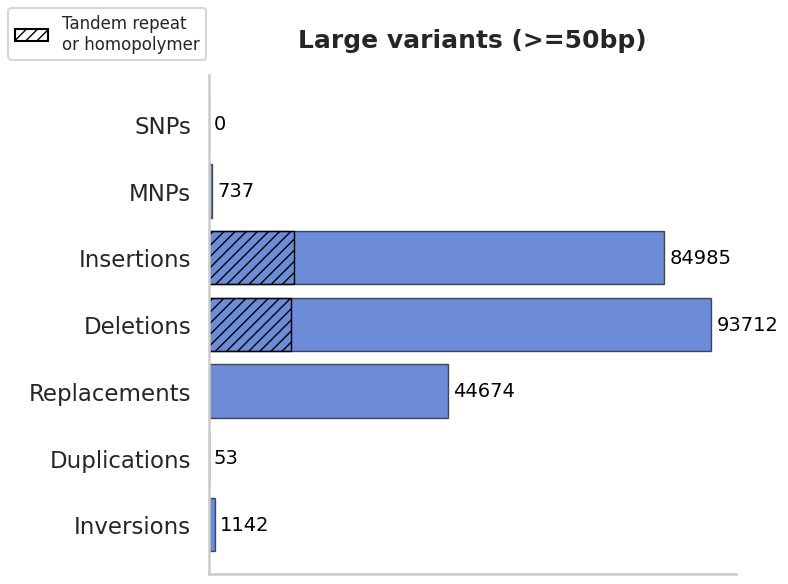

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import ScalarFormatter

categories = ['SNPs', 'MNPs', 'Insertions', 'Deletions', 'Replacements', 'Duplications', 'Inversions']
values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Large_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Large_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Large_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Deletion']['Large_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Replacement']['Large_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Duplication']['Large_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Inversion']['Large_Variants'])]

repeat_values = [int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'SNP']['Large_Variants']), 
          int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'MNP']['Large_Variants']), 
          int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'Insertion']['Large_Variants']), 
          int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'Deletion']['Large_Variants']), 
          int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'Replacement']['Large_Variants']),
          int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'Duplication']['Large_Variants']),
          int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'Inversion']['Large_Variants'])]

# Data Preparation
data = pd.DataFrame({'Category': categories, 'Count': values, 'Repeat Count': repeat_values})

# Seaborn Theme
sns.set_theme(style="whitegrid", palette="muted", context="talk")

# Define max count for offset calculation
max_count = data['Count'].max()
offset = 0.01 * max_count

# Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot Normal Bars
bars = sns.barplot(y='Category', x='Count', data=data, linewidth=1, edgecolor='black', color=colors['primary'], alpha=0.65)

# Add hatched bars for repeated values
for i, (total_value, repeated_value) in enumerate(zip(data['Count'], data['Repeat Count'])):
    if repeated_value > 0:  # Ensure non-zero repeated values
        ax.barh(y=i, width=repeated_value, color="none", edgecolor=colors["hatch"], hatch="///", linewidth=1)

# Add titles and labels
plt.title('Large variants (>=50bp)', fontsize=18, weight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')

# Customize the x-axis to use scientific notation
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))  # Apply scientific notation to the x-axis
ax.set_xticklabels([])
ax.grid(False)

# **Add Custom Legend**
legend_handles = [
    mpatches.Patch(facecolor="none", edgecolor="black", hatch="///", label=f"Tandem repeat\nor homopolymer")  # Hatched part
]

fig.legend(handles=legend_handles, loc="upper left", fontsize=12)

# Customize the grid and remove top/right spines for a cleaner look
sns.despine(left=False, bottom=False)

# Add value labels next to bars
for i, v in enumerate(data['Count']):
    plt.text(v + offset, i, f"{v}", va='center', fontsize=14, color='black')

# Show the plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/large_variant_bar_chart_all_chr.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/large_variant_bar_chart_all_chr.png', dpi=600, bbox_inches='tight', format='png')


plt.show()


Chart: Focus on off-linear variants

/tmp/ipykernel_23586/1956123530.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Non_Linear_Variants']),
/tmp/ipykernel_23586/1956123530.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Non_Linear_Variants']),
/tmp/ipykernel_23586/1956123530.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Non_Linear_Variants']),
/tmp/ipykernel_23586/1956123530.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(

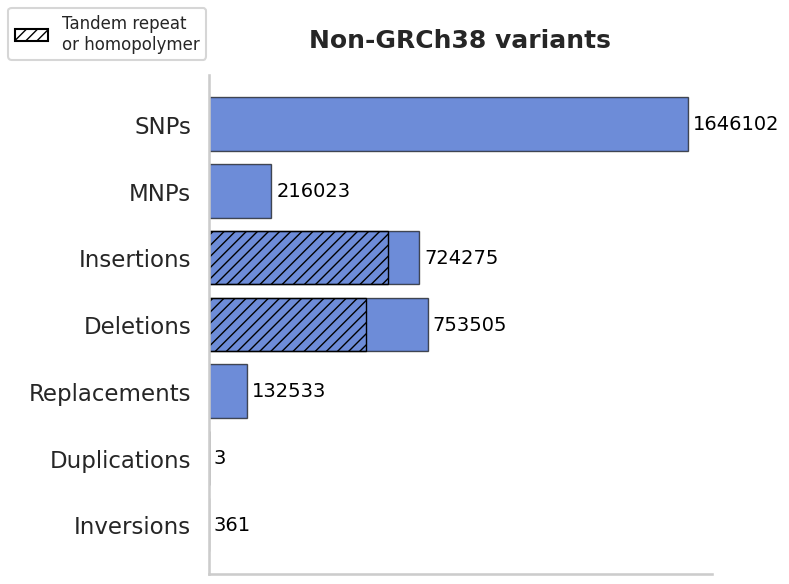

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

categories = ['SNPs', 'MNPs', 'Insertions', 'Deletions', 'Replacements', 'Duplications', 'Inversions']
values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Non_Linear_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Non_Linear_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Non_Linear_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Deletion']['Non_Linear_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Replacement']['Non_Linear_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Duplication']['Non_Linear_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Inversion']['Non_Linear_Variants'])]

repeat_values = [int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'SNP']['Non_Linear_Variants']), 
          int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'MNP']['Non_Linear_Variants']), 
          int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'Insertion']['Non_Linear_Variants']), 
          int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'Deletion']['Non_Linear_Variants']), 
          int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'Replacement']['Non_Linear_Variants']),
          int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'Duplication']['Non_Linear_Variants']),
          int(repeated_var_summary_df[repeated_var_summary_df['Variant Type'] == 'Inversion']['Non_Linear_Variants'])]

# Data Preparation
data = pd.DataFrame({'Category': categories, 'Count': values, 'Repeat Count': repeat_values})

# Seaborn Theme
sns.set_theme(style="whitegrid", palette="muted", context="talk")

# Define max count for offset calculation
max_count = data['Count'].max()
offset = 0.01 * max_count

# Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot Normal Bars
bars = sns.barplot(y='Category', x='Count', data=data, linewidth=1, edgecolor='black', color=colors['primary'], alpha=0.65)

# Add hatched bars for repeated values
for i, (total_value, repeated_value) in enumerate(zip(data['Count'], data['Repeat Count'])):
    if repeated_value > 0:  # Ensure non-zero repeated values
        ax.barh(y=i, width=repeated_value, color="none", edgecolor=colors["hatch"], hatch="///", linewidth=1)

# Add titles and labels
plt.title('Non-GRCh38 variants', fontsize=18, weight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')

# Customize the x-axis to use scientific notation
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))  # Apply scientific notation to the x-axis
ax.set_xticklabels([])
ax.grid(False)

# **Add Custom Legend**
legend_handles = [
    mpatches.Patch(facecolor="none", edgecolor="black", hatch="///", label=f"Tandem repeat\nor homopolymer")  # Hatched part
]

fig.legend(handles=legend_handles, loc="upper left", fontsize=12)

# Customize the grid and remove top/right spines for a cleaner look
sns.despine(left=False, bottom=False)

# Add value labels next to bars
for i, v in enumerate(data['Count']):
    plt.text(v + offset, i, f"{v}", va='center', fontsize=14, color='black')

# Show the plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/offlinear_variant_bar_chart_all_chr.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/offlinear_variant_bar_chart_all_chr.png', dpi=600, bbox_inches='tight', format='png')


plt.show()


Chart: SNP By Region

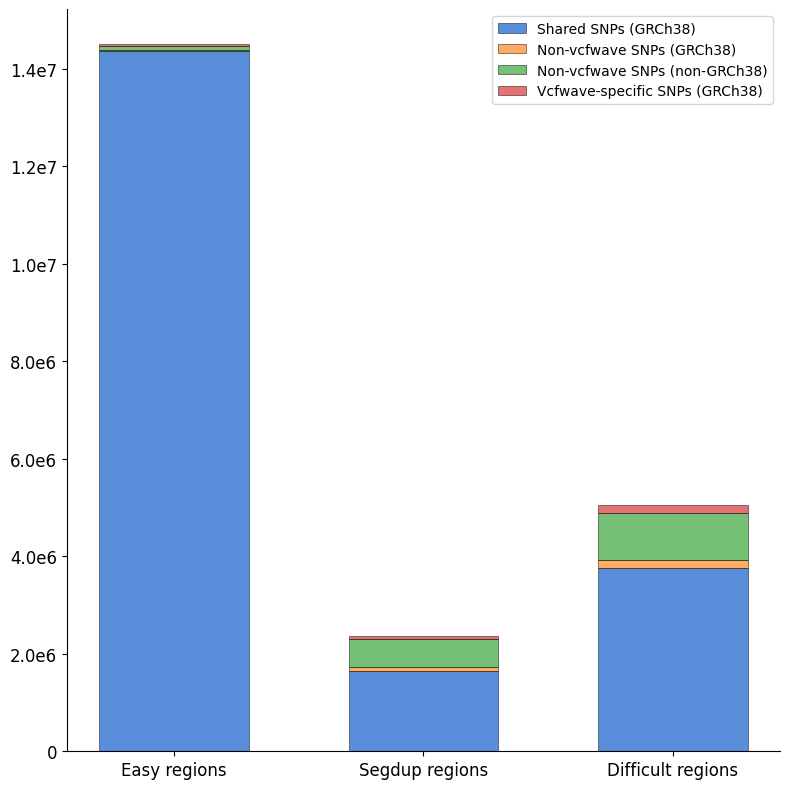

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import numpy as np

shared_count_list = region_df['Shared'].to_list()
ourlinear_count_list = region_df['Ourvcf_linear'].to_list()
ourofflinear_count_list = region_df['Ourvcf_offlinear'].to_list()
raw_count_list = region_df['Vcfwave_only'].to_list()

# Data for the stacked bar chart
categories = ['Easy regions', 'Segdup regions', 'Difficult regions']  # n categories
data_stack1 = shared_count_list
data_stack2 = ourlinear_count_list
data_stack3 = ourofflinear_count_list
data_stack4 = raw_count_list

# Define bar positions and width
x = np.arange(len(categories))  # X positions for the bars
bar_width = 0.6

# Create the figure and axis
plt.figure(figsize=(8, 8))

fancy_colors = ["#0052C8", "#ff7f0e", "#2ca02c", "#d62728"]
alpha_value = 0.65
lw = 0.5

# Create the stacked bars
plt.bar(x, data_stack1, width=bar_width, label='Shared SNPs (GRCh38)', linewidth=lw, edgecolor='black', color=fancy_colors[0], alpha=alpha_value)
plt.bar(x, data_stack2, width=bar_width, bottom=data_stack1, label='Non-vcfwave SNPs (GRCh38)', linewidth=lw, edgecolor='black', 
        color=fancy_colors[1], alpha=alpha_value)
plt.bar(x, data_stack3, width=bar_width, bottom=np.array(data_stack1) + np.array(data_stack2), 
        label='Non-vcfwave SNPs (non-GRCh38)', linewidth=lw, edgecolor='black', color=fancy_colors[2], alpha=alpha_value)
plt.bar(x, data_stack4, width=bar_width, bottom=np.array(data_stack1) + np.array(data_stack2) + np.array(data_stack3), 
        label='Vcfwave-specific SNPs (GRCh38)', linewidth=lw, edgecolor='black', color=fancy_colors[3], alpha=alpha_value)

# Annotate values on each stack
# for i, value in enumerate(data_stack1):
#     plt.text(x[i], value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 1
# for i, value in enumerate(data_stack2):
#     bottom_value = data_stack1[i]
#     plt.text(x[i], bottom_value + value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 2
# for i, value in enumerate(data_stack3):
#     bottom_value = data_stack1[i] + data_stack2[i]
#     plt.text(x[i], bottom_value + value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 3

# if wavevcf:
#     plt.title('SNP comparison (ourvcf vs. vcfwave)', fontsize=18, weight='bold', pad=20)
# else:
#     plt.title('SNP comparison (ourvcf vs. rawvcf)', fontsize=18, weight='bold', pad=20)

# Add titles and labels
plt.xlabel('', fontsize=14)
# plt.ylabel('Count', fontsize=14)
plt.xticks(x, categories, fontsize=12)
plt.yticks(fontsize=12)

# Add a legend
plt.legend(fontsize=10, title_fontsize=14, loc='upper right')

# Add gridlines
plt.grid(False)

# Customize the x-axis to use scientific notation
ax = plt.gca()  # Get the current axes
# ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
# ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# Define a custom formatter function
def scientific_notation_flexible(value, pos):
    if value == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(value))))
    base = value / 10**exponent
    return f"{base:.1f}e{exponent}"

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(scientific_notation_flexible))

# Customize the axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Save the chart as a high-resolution image
if wavevcf:
    plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/wave_snp_stacked_bar_chart_all_chr_by_region.pdf', dpi=600, bbox_inches='tight', format='pdf')
    plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/wave_snp_stacked_bar_chart_all_chr_by_region.png', dpi=600, bbox_inches='tight', format='png')
else:
    plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/raw_snp_stacked_bar_chart_all_chr_by_region.pdf', dpi=600, bbox_inches='tight', format='pdf')
    plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/raw_snp_stacked_bar_chart_all_chr_by_region.png', dpi=600, bbox_inches='tight', format='png')

# Show the plot
plt.show()


Chart: SNP By AC and Region in Segdup or Difficult

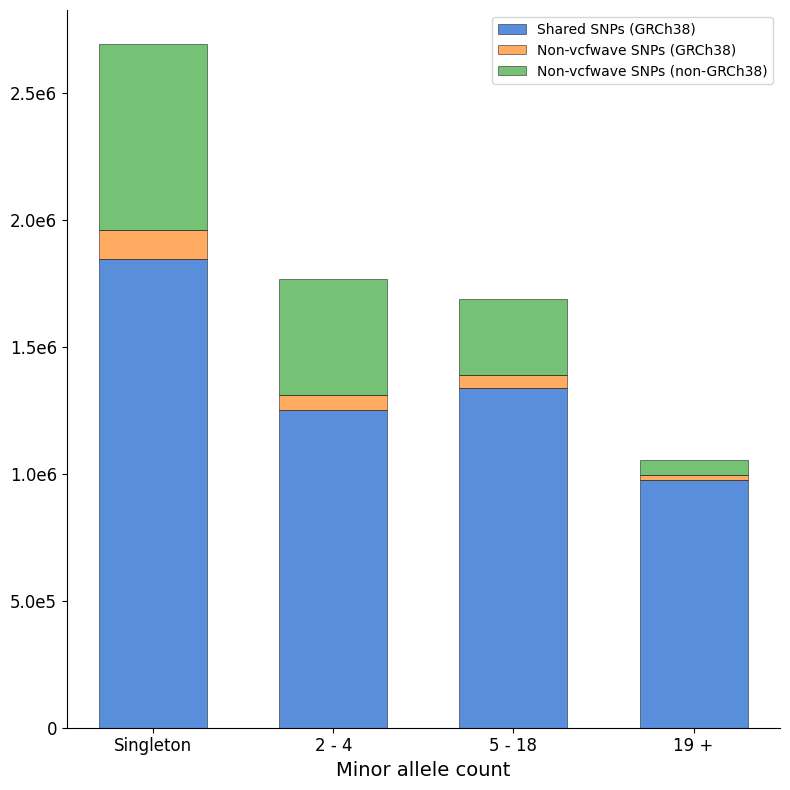

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import numpy as np

simple_count_list = range_df['Shared'].to_list()
complex_count_list = range_df['Ourvcf_linear'].to_list()
nonlinear_count_list = range_df['Ourvcf_offlinear'].to_list()

# Data for the stacked bar chart
categories = ['Singleton', '2 - 4', '5 - 18', '19 +']  # n categories
data_stack1 = simple_count_list  # Values for the first stack
data_stack2 = complex_count_list  # Values for the second stack
data_stack3 = nonlinear_count_list  # Values for the third stack

# Define bar positions and width
x = np.arange(len(categories))  # X positions for the bars
bar_width = 0.6

# Create the figure and axis
plt.figure(figsize=(8, 8))

fancy_colors = ["#0052C8", "#ff7f0e", "#2ca02c", "#d62728"]
alpha_value = 0.65
lw = 0.5

# Create the stacked bars
plt.bar(x, data_stack1, width=bar_width, label='Shared SNPs (GRCh38)', linewidth=lw, edgecolor='black', color=fancy_colors[0], alpha=alpha_value)
plt.bar(x, data_stack2, width=bar_width, bottom=data_stack1, label='Non-vcfwave SNPs (GRCh38)', linewidth=lw, edgecolor='black', 
        color=fancy_colors[1], alpha=alpha_value)
plt.bar(x, data_stack3, width=bar_width, bottom=np.array(data_stack1) + np.array(data_stack2), 
        label='Non-vcfwave SNPs (non-GRCh38)', linewidth=lw, edgecolor='black', color=fancy_colors[2], alpha=alpha_value)

# Annotate values on each stack
# for i, value in enumerate(data_stack1):
#     plt.text(x[i], value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 1
# for i, value in enumerate(data_stack2):
#     bottom_value = data_stack1[i]
#     plt.text(x[i], bottom_value + value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 2
# for i, value in enumerate(data_stack3):
#     bottom_value = data_stack1[i] + data_stack2[i]
#     plt.text(x[i], bottom_value + value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 3

# if wavevcf:
#     plt.title('SNP comparison with vcfwave (segdup and difficult region)', fontsize=18, weight='bold', pad=20)
# else:
#     plt.title('SNP comparison with raw vcf (segdup and difficult region)', fontsize=18, weight='bold', pad=20)

# Customize the x-axis to use scientific notation
ax = plt.gca()  # Get the current axes
# ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
# ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# Define a custom formatter function
def scientific_notation_flexible(value, pos):
    if value == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(value))))
    base = value / 10**exponent
    return f"{base:.1f}e{exponent}"

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(scientific_notation_flexible))

# Add titles and labels
plt.xlabel('Minor allele count', fontsize=14)
# plt.ylabel('Count', fontsize=14)
plt.xticks(x, categories, fontsize=12)
plt.yticks(fontsize=12)

# Add a legend
plt.legend(fontsize=10, title_fontsize=14, loc='upper right')

# Add gridlines
plt.grid(False)

# Customize the axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Save the chart as a high-resolution image
if wavevcf:
    plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/wave_snp_stacked_bar_chart_all_chr_by_ac_in_not_easy_region.pdf', dpi=600, bbox_inches='tight', format='pdf')
    plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/wave_snp_stacked_bar_chart_all_chr_by_ac_in_not_easy_region.png', dpi=600, bbox_inches='tight', format='png')
else:
    plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/raw_snp_stacked_bar_chart_all_chr_by_ac_in_not_easy_region.pdf', dpi=600, bbox_inches='tight', format='pdf')
    plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/raw_snp_stacked_bar_chart_all_chr_by_ac_in_not_easy_region.png', dpi=600, bbox_inches='tight', format='png')

# Show the plot
plt.show()


Assemble Figure 2

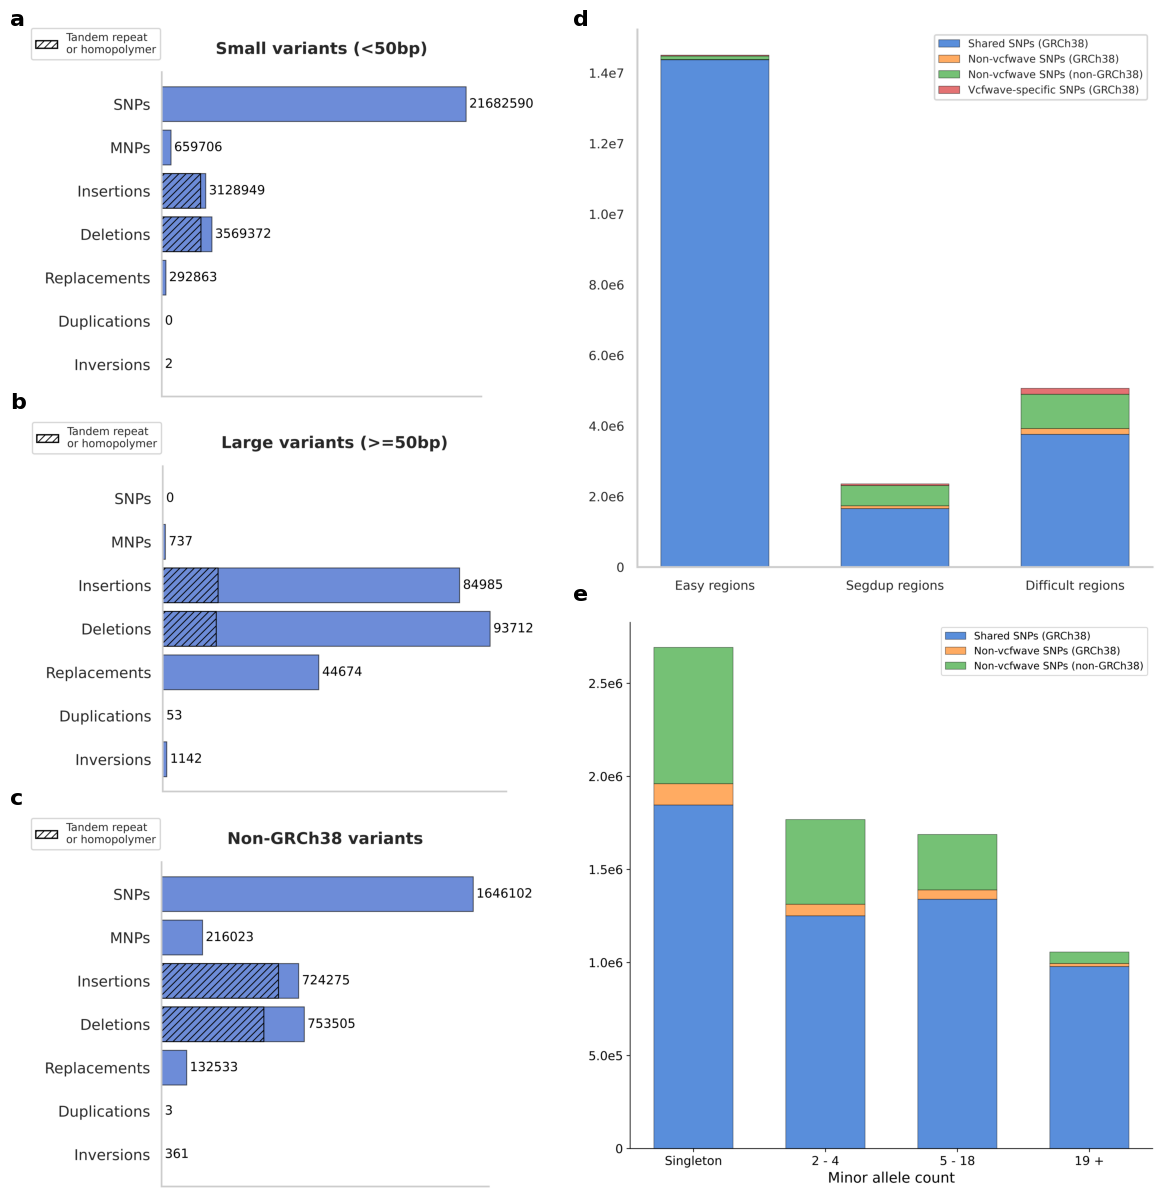

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

# Load images
img1 = mpimg.imread("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/small_variant_bar_chart_all_chr.png")
img2 = mpimg.imread("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/large_variant_bar_chart_all_chr.png")
img3 = mpimg.imread("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/offlinear_variant_bar_chart_all_chr.png")
img4 = mpimg.imread("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/wave_snp_stacked_bar_chart_all_chr_by_region.png")
img5 = mpimg.imread("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/wave_snp_stacked_bar_chart_all_chr_by_ac_in_not_easy_region.png")

# Create figure and define a flexible grid layout
fig = plt.figure(figsize=(12, 12))  # Define overall figure size
gs = gridspec.GridSpec(6, 2, width_ratios=[1, 1.25], height_ratios=[1, 1, 1, 1, 1, 1])  

# First three charts in the first column (one per row)
ax1 = fig.add_subplot(gs[0:2, 0])  # Row 1, Col 1
ax2 = fig.add_subplot(gs[2:4, 0])  # Row 2, Col 1
ax3 = fig.add_subplot(gs[4:6, 0])  # Row 3, Col 1

# Make Chart 4 and Chart 5 evenly share the second column
ax4 = fig.add_subplot(gs[0:3, 1])  # Chart 4 takes Row 1
ax5 = fig.add_subplot(gs[3:6, 1])  # Chart 5 takes Row 2 & 3

# Display images
ax1.imshow(img1)
ax2.imshow(img2)
ax3.imshow(img3)
ax4.imshow(img4)
ax5.imshow(img5)

# Remove axis labels and ticks for a clean layout
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.axis("off")

# Define label positions to match the adjusted layout
label_positions = [(0.001, 0.999),  # a (Top-left)
                   (0.47, 0.999),  # d (Top-right)
                   (0.001, 0.68),  # b (Middle-left)
                   (0.001, 0.35),  # c (Bottom-left)
                   (0.47, 0.52)]  # e (Middle-right)

labels = ["a", "d", "b", "c", "e"]

# Add global labels to the whole figure
for (x, y), label in zip(label_positions, labels):
    fig.text(x, y, label, fontsize=16, fontweight="bold", va="top", ha="left", color="black")

# Adjust layout and save the final figure
plt.tight_layout()
plt.savefig("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/assembled_figure2.pdf", bbox_inches="tight", dpi=600)
plt.savefig("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/assembled_figure2.png", bbox_inches="tight", dpi=600)

# Show the final image
plt.show()


Chart: Additional bar charts for variants

/tmp/ipykernel_31638/4246181639.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Large_Common_Variants']),
/tmp/ipykernel_31638/4246181639.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Large_Common_Variants']),
/tmp/ipykernel_31638/4246181639.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Large_Common_Variants']),
/tmp/ipykernel_31638/4246181639.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Us

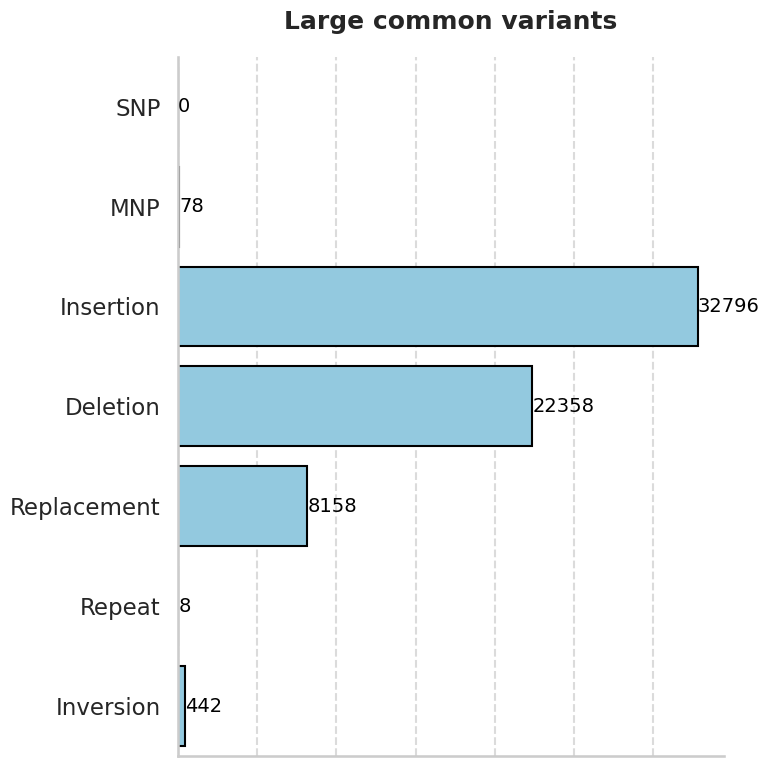

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

categories = ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Repeat', 'Inversion']
values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Large_Common_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Large_Common_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Large_Common_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Deletion']['Large_Common_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Replacement']['Large_Common_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Repeat']['Large_Common_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Inversion']['Large_Common_Variants'])]

# Data
data = pd.DataFrame({
    'Category': categories,
    'Count': values
})

# Set a professional style
sns.set_theme(style="whitegrid", palette="muted", context="talk")

#data = data.sort_values(by='Count', ascending=False)

# Create the horizontal bar chart
plt.figure(figsize=(8, 8))  # Set the figure size
sns.barplot(y='Category', x='Count', data=data, edgecolor='black', color="skyblue")

# Add titles and labels
plt.title('Large common variants', fontsize=18, weight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')

# Customize the x-axis to use scientific notation
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))  # Apply scientific notation to the x-axis
ax.set_xticklabels([])
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Customize the grid and remove top/right spines for a cleaner look
sns.despine(left=False, bottom=False)

# Add value labels next to bars
for i, v in enumerate(data['Count']):
    plt.text(v + 2, i, f"{v}", va='center', fontsize=14, color='black')

# Show the plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/large_common_variant_bar_chart_all_chr.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/large_common_variant_bar_chart_all_chr.png', dpi=600, bbox_inches='tight', format='png')

plt.show()


/tmp/ipykernel_31638/2306344848.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Non_Linear_Large_Variants']),
/tmp/ipykernel_31638/2306344848.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Non_Linear_Large_Variants']),
/tmp/ipykernel_31638/2306344848.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Non_Linear_Large_Variants']),
/tmp/ipykernel_31638/2306344848.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in th

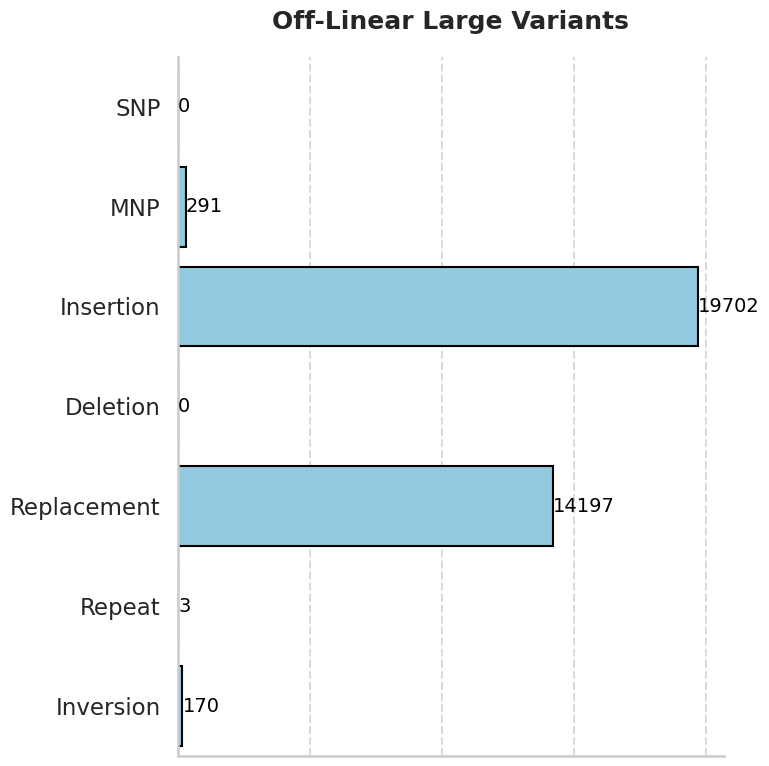

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

categories = ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Repeat', 'Inversion']
values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Non_Linear_Large_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Non_Linear_Large_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Non_Linear_Large_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Deletion']['Non_Linear_Large_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Replacement']['Non_Linear_Large_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Repeat']['Non_Linear_Large_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Inversion']['Non_Linear_Large_Variants'])]

# Data
data = pd.DataFrame({
    'Category': categories,
    'Count': values
})

# Set a professional style
sns.set_theme(style="whitegrid", palette="muted", context="talk")

#data = data.sort_values(by='Count', ascending=False)

# Create the horizontal bar chart
plt.figure(figsize=(8, 8))  # Set the figure size
sns.barplot(y='Category', x='Count', data=data, edgecolor='black', color="skyblue")

# Add titles and labels
plt.title('Off-Linear Large Variants', fontsize=18, weight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')

ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))  # Apply scientific notation to the x-axis
ax.set_xticklabels([])
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Customize the grid and remove top/right spines for a cleaner look
sns.despine(left=False, bottom=False)

# Add value labels next to bars
for i, v in enumerate(data['Count']):
    plt.text(v + 2, i, f"{v}", va='center', fontsize=14, color='black')

# Show the plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/offlinear_large_variant_bar_chart_all_chr.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/offlinear_large_variant_bar_chart_all_chr.png', dpi=600, bbox_inches='tight', format='png')

plt.show()


/tmp/ipykernel_31638/4011593329.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Non_Linear_Large_Common_Variants']),
/tmp/ipykernel_31638/4011593329.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Non_Linear_Large_Common_Variants']),
/tmp/ipykernel_31638/4011593329.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Non_Linear_Large_Common_Variants']),
/tmp/ipykernel_31638/4011593329.py:9: FutureWarning: Calling int on a single element Series is deprecated and will ra

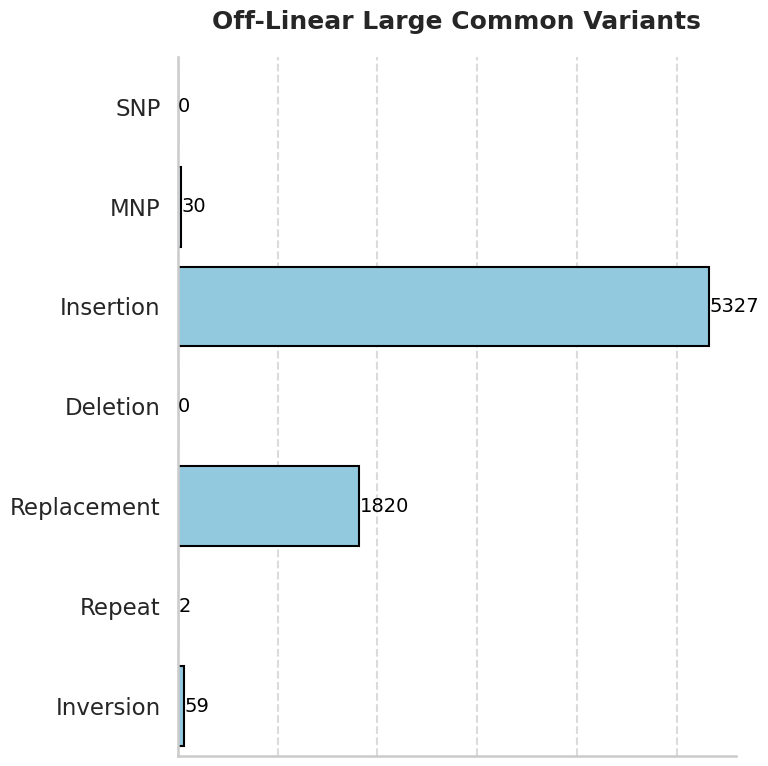

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

categories = ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Repeat', 'Inversion']
values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Non_Linear_Large_Common_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Non_Linear_Large_Common_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Non_Linear_Large_Common_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Deletion']['Non_Linear_Large_Common_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Replacement']['Non_Linear_Large_Common_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Repeat']['Non_Linear_Large_Common_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Inversion']['Non_Linear_Large_Common_Variants'])]

# Data
data = pd.DataFrame({
    'Category': categories,
    'Count': values
})

# Set a professional style
sns.set_theme(style="whitegrid", palette="muted", context="talk")

#data = data.sort_values(by='Count', ascending=False)

# Create the horizontal bar chart
plt.figure(figsize=(8, 8))  # Set the figure size
sns.barplot(y='Category', x='Count', data=data, edgecolor='black', color="skyblue")

# Add titles and labels
plt.title('Off-Linear Large Common Variants', fontsize=18, weight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')

ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))  # Apply scientific notation to the x-axis
ax.set_xticklabels([])
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Customize the grid and remove top/right spines for a cleaner look
sns.despine(left=False, bottom=False)

# Add value labels next to bars
for i, v in enumerate(data['Count']):
    plt.text(v + 2, i, f"{v}", va='center', fontsize=14, color='black')

# Show the plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/offlinear_large_common_variant_bar_chart_all_chr.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/offlinear_large_common_variant_bar_chart_all_chr.png', dpi=600, bbox_inches='tight', format='png')

plt.show()


Chart: Histogram for bubbles with 3 alleles and 3+ alleles

In [4]:
import pandas as pd

ac_dir = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Bubble_summary"

df_list = []
for i in range(1,23):
    ac_df_path = f"{ac_dir}/bubble_allele_summary_chr{i}.tsv"
    ac_df = pd.read_csv(ac_df_path, sep='\t')
    df_list.append(ac_df)

concated_df = pd.concat(df_list)
concated_df.columns = ['Chromosome'] + concated_df.columns[1:].tolist()
concated_df['Chromosome'] = [chr+1 for chr, df in enumerate(df_list) for _ in range(len(df))]
concated_df.to_csv(f"{ac_dir}/bubble_allele_summary_all_chr.tsv", index=False, sep='\t')

: 

In [3]:
import pandas as pd

ac_dir = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Bubble_summary"

concated_df = pd.read_csv(f"{ac_dir}/bubble_allele_summary_all_chr.tsv", sep='\t')

variant_df = concated_df[concated_df.apply(lambda x: int(x['num_variants']) >= 2 and int(x['Level']) == 0, axis=1)]

def filter_level_multiallelic(x, colname):
    num_allele = x[colname]
    if num_allele == '.':
        return False
    level = x['Level']
    return int(num_allele) >= 2 and int(level) == 0

raw_vcf_allele_df = concated_df[concated_df.apply(lambda x: filter_level_multiallelic(x, 'raw_vcf_allele_count'), axis=1)]
vcfwave_allele_df = concated_df[concated_df.apply(lambda x: filter_level_multiallelic(x, 'vcfwave_allele_count'), axis=1)]

variant_data = variant_df['num_variants'].to_numpy().astype(int)
raw_vcf_allele_data = raw_vcf_allele_df['raw_vcf_allele_count'].to_numpy().astype(int)
vcfwave_allele_data = vcfwave_allele_df['vcfwave_allele_count'].to_numpy().astype(int)

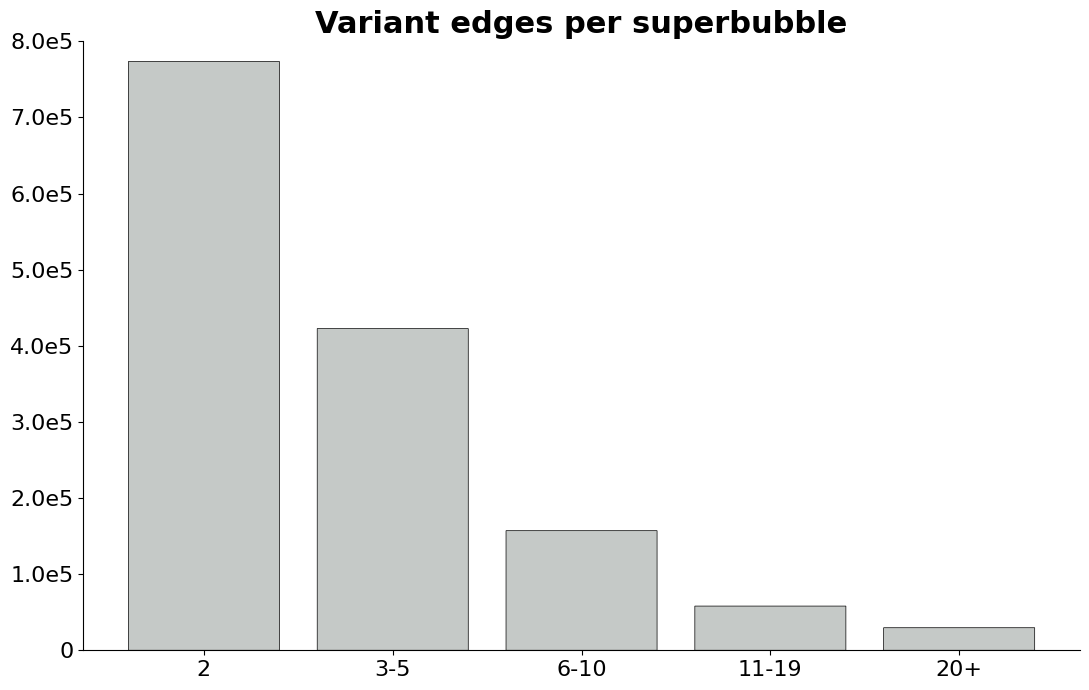

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyBboxPatch
from matplotlib.ticker import ScalarFormatter, FuncFormatter

# Example data
data = variant_data  # Generate some data between 0 and 60

# Define custom bins
bins = list(range(2, 4)) + [6, 11, 20] + [float('inf')]
bin_labels = [f"{i}" for i in range(2, 3)] + ["3-5", "6-10", "11-19", "20+"]

# Compute histogram
counts, bin_edges = np.histogram(data, bins=bins)

# Create bar positions
bar_positions = np.arange(len(counts))

# Create figure
fig, ax = plt.subplots(figsize=(11, 7))

# Plot histogram bars (initially hidden)
bars = plt.bar(bar_positions, counts, edgecolor="black", alpha=0, color="none")  # Hide original bars

# Replace each bar with a rounded rectangle
for bar, count in zip(bars, counts):
    x, y = bar.get_x(), bar.get_y()
    width, height = bar.get_width(), bar.get_height()

    # Create rounded bar
    rounded_bar = FancyBboxPatch(
        (x, y), width, height, 
        boxstyle="round,pad=0",  # Controls corner roundness
        facecolor="#C5C9C7", edgecolor="black", linewidth=0.5, alpha=1
    )
    ax.add_patch(rounded_bar)

# Add custom x-axis labels
plt.xticks(bar_positions, bin_labels, fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(top=800000)

plt.title("Variant edges per superbubble", fontsize=22, weight='bold')
# plt.xlabel("Number of variants", fontsize=16)

# Remove y-axis labels for clean formatting
# ax.set_yticklabels([])

# Hide grid lines and unnecessary spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

# Customize the x-axis to use scientific notation
gca = plt.gca()

# Define a custom formatter function
def scientific_notation_flexible(value, pos):
    if value == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(value))))
    base = value / 10**exponent
    return f"{base:.1f}e{exponent}"

# Apply the custom formatter to the y-axis
gca.yaxis.set_major_formatter(FuncFormatter(scientific_notation_flexible))

# Annotate bar counts
# y_bias = 0.01 * max(counts)
# for i, count in enumerate(counts):
#     plt.text(i, count + y_bias, str(count), ha="center", fontsize=15)

# Adjust layout
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/histogram_num_vars_all_chr.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/histogram_num_vars_all_chr.png', dpi=600, bbox_inches='tight', format='png')

# Show plot
plt.show()


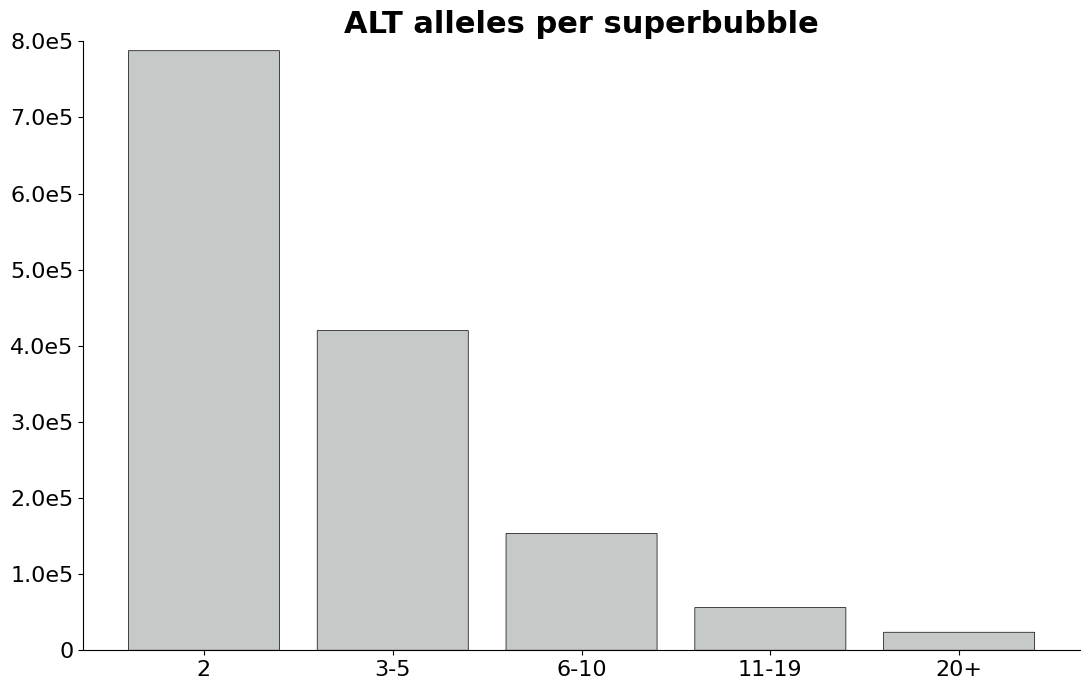

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyBboxPatch
from matplotlib.ticker import ScalarFormatter, FuncFormatter

# Example data
data = raw_vcf_allele_data  # Generate some data between 0 and 60

# Compute histogram
counts, bin_edges = np.histogram(data, bins=bins)

# Create bar positions
bar_positions = np.arange(len(counts))

# Create figure
fig, ax = plt.subplots(figsize=(11, 7))

# Plot histogram bars (initially hidden)
bars = plt.bar(bar_positions, counts, edgecolor="black", alpha=0, color="none")  # Hide original bars

# Replace each bar with a rounded rectangle
for bar, count in zip(bars, counts):
    x, y = bar.get_x(), bar.get_y()
    width, height = bar.get_width(), bar.get_height()

    # Create rounded bar
    rounded_bar = FancyBboxPatch(
        (x, y), width, height, 
        boxstyle="round,pad=0",  # Controls corner roundness
        facecolor="#C5C9C7", edgecolor="black", linewidth=0.5, alpha=1
    )
    ax.add_patch(rounded_bar)

# Add custom x-axis labels
plt.xticks(bar_positions, bin_labels, fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(top=800000)

# Add titles and labels
plt.title("ALT alleles per superbubble", fontsize=22, weight='bold')
# plt.xlabel("Number of alternative alleles", fontsize=16)
# plt.ylabel("Frequency", fontsize=14)

ax = plt.gca()  # Get the current axes
ax.set_yticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

# Customize the x-axis to use scientific notation
gca = plt.gca()

# Define a custom formatter function
def scientific_notation_flexible(value, pos):
    if value == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(value))))
    base = value / 10**exponent
    return f"{base:.1f}e{exponent}"

# Apply the custom formatter to the y-axis
gca.yaxis.set_major_formatter(FuncFormatter(scientific_notation_flexible))

# y_bias = 0.01 * max(counts)

# # Annotate bar counts
# for i, count in enumerate(counts):
#     plt.text(i, count + y_bias, str(count), ha="center", fontsize=15)

# Show plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/histogram_num_alleles_all_chr.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/histogram_num_alleles_all_chr.png', dpi=600, bbox_inches='tight', format='png')

plt.show()

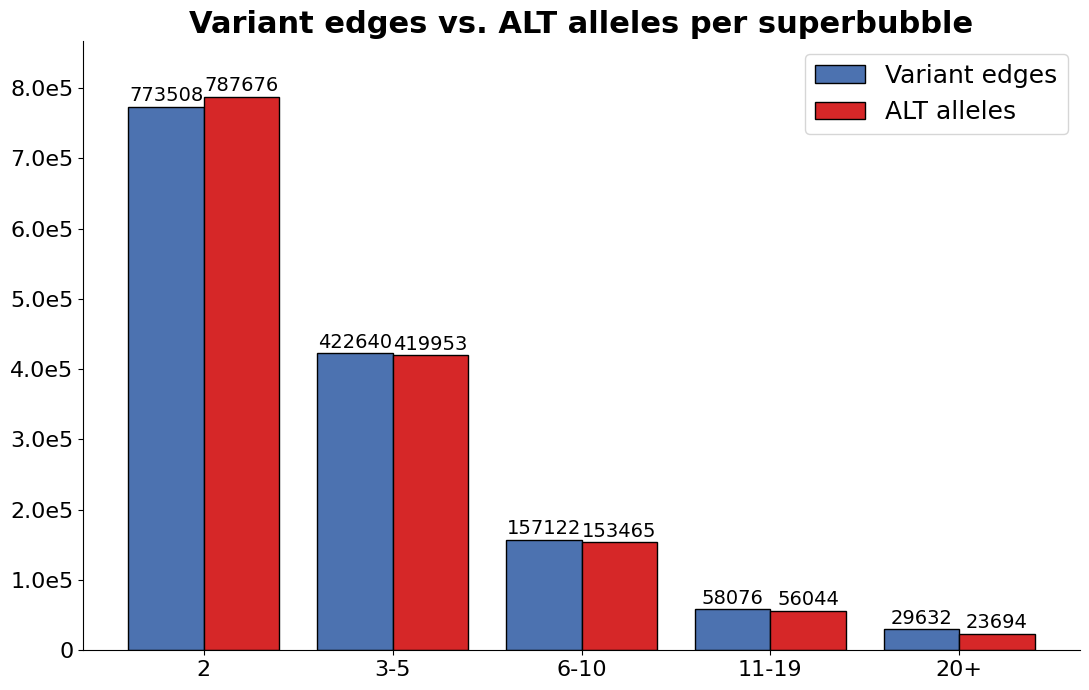

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# Example data (Replace with actual data)
data_edges = variant_data
data_alt = raw_vcf_allele_data

# Define bins (Ensure both datasets use the same binning)
bins = list(range(2, 4)) + [6, 11, 20] + [float('inf')]
bin_labels = [f"{i}" for i in range(2, 3)] + ["3-5", "6-10", "11-19", "20+"]

# Compute histograms
counts_edges, _ = np.histogram(data_edges, bins=bins)
counts_alt, _ = np.histogram(data_alt, bins=bins)

# Create bar positions (shift groups)
bar_positions = np.arange(len(counts_edges))
bar_width = 0.4  # Bar width for grouped bars

# Create figure
fig, ax = plt.subplots(figsize=(11, 7))

# Plot first group (Variant Edges)
bars_edges = plt.bar(bar_positions - bar_width/2, counts_edges, width=bar_width, 
                     color="#4C72B0", edgecolor="black", label="Variant edges")

# Plot second group (ALT Alleles)
bars_alt = plt.bar(bar_positions + bar_width/2, counts_alt, width=bar_width, 
                   color="#D62728", edgecolor="black", label="ALT alleles")

# Add x-axis labels
plt.xticks(bar_positions, bin_labels, fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(top=max(max(counts_edges), max(counts_alt)) * 1.1)

# Add title and labels
plt.title("Variant edges vs. ALT alleles per superbubble", fontsize=22, weight='bold')
# ax.set_xlabel("Number of Variants", fontsize=16)

# Remove y-axis labels for a clean look
ax.set_yticklabels([])

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

# Define scientific notation formatter
def scientific_notation_flexible(value, pos):
    if value == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(value))))
    base = value / 10**exponent
    return f"{base:.1f}e{exponent}"

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(scientific_notation_flexible))

# Add bar values above bars
for bar in bars_edges:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01 * max(counts_edges), 
                 f"{int(height)}", ha='center', fontsize=14, color="black")

for bar in bars_alt:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01 * max(counts_alt), 
                 f"{int(height)}", ha='center', fontsize=14, color="black")

# Add a legend
plt.legend(loc="upper right", fontsize=18)

# Adjust layout
plt.tight_layout()

# Save the chart
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/grouped_histogram_num_variants_vs_num_alleles.png', dpi=600, format='png')
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/grouped_histogram_num_variants_vs_num_alleles.pdf', dpi=600, format='pdf')

# Show plot
plt.show()


Chart: Scatter plot for bubbles on num_variant vs num_alt_allele

In [4]:
level0_df = concated_df[concated_df.apply(lambda x: int(x['Level']) == 0 and x['raw_vcf_allele_count'] != '.', axis=1)]

/tmp/ipykernel_17265/2674200409.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  original_cmap = cm.get_cmap('gray_r')  # Reverse gray colormap


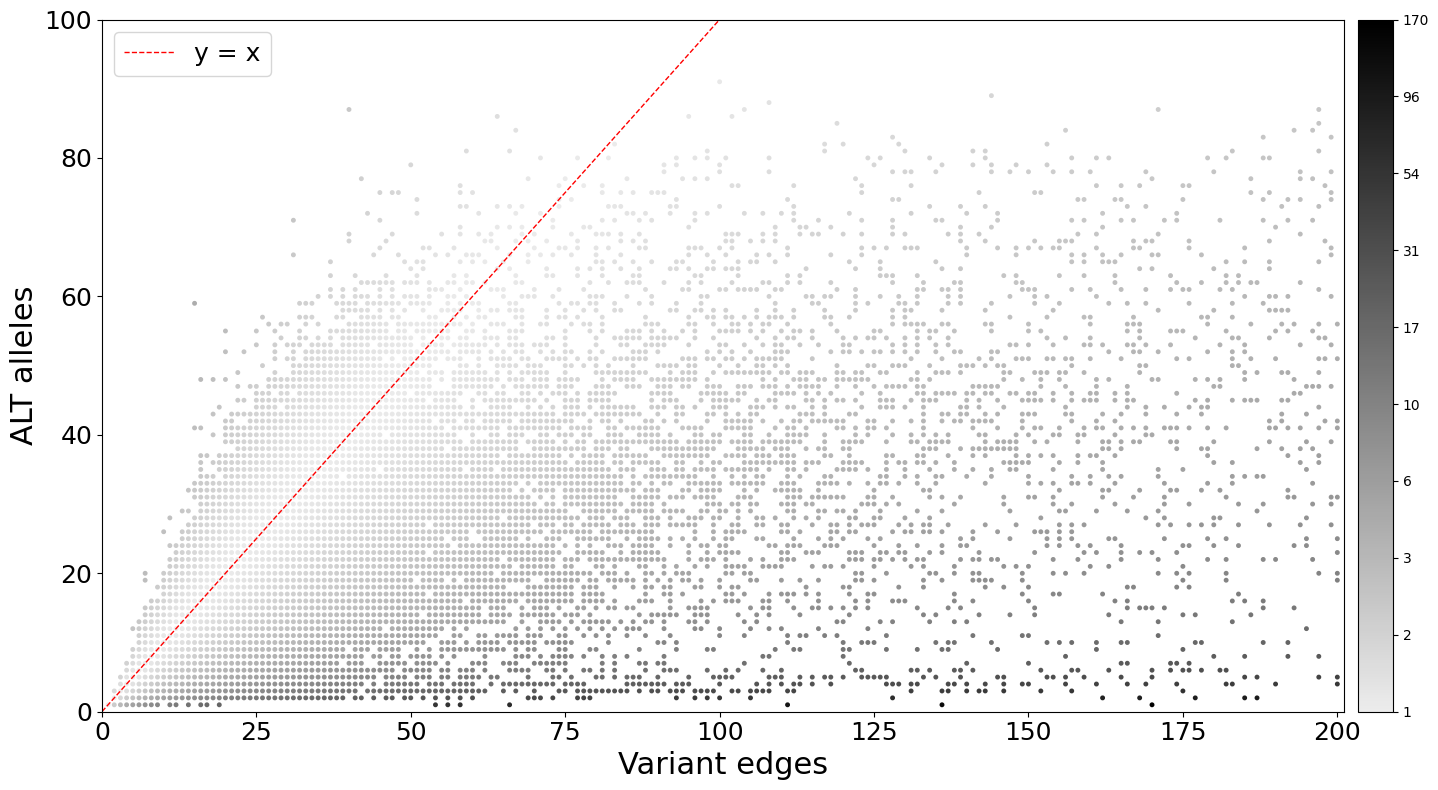

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
import matplotlib.colors as mcolors

x = level0_df['num_variants'].to_numpy().astype(int)
y = level0_df['raw_vcf_allele_count'].to_numpy().astype(int)

# Set equal axis limits
min_range = 0
max_range = 100
# min_range = 0
# max_range = min(x.max(), y.max())

sample_index = (x >= min_range) & (x <= 2*max_range) & (y >= min_range) & (y <= max_range)
x = x[sample_index]
y = y[sample_index]

unique_points = np.array(list(set(zip(x, y))))
x = unique_points[:, 0]
y = unique_points[:, 1]

alpha_values = [(a / b) if a > b else (b / a) for a, b in zip(x, y)]
log_alpha_values = np.log2(alpha_values)
# log_alpha_values = alpha_values
normalized_alpha = 0.075 + (log_alpha_values - np.min(log_alpha_values)) / (np.max(log_alpha_values) - np.min(log_alpha_values)) * 0.925

# Scatter plot
fig, ax = plt.subplots(figsize=(14, 7))  # Set figure size
sc = ax.scatter(x, y, color="black", marker='.', edgecolors='none', s=50, alpha=normalized_alpha)

plt.xlim(min_range, 2.01*max_range)
plt.ylim(min_range, max_range)

# Add y = x line
ax.plot([min_range, max_range], [min_range, max_range], color="red", linestyle="--", linewidth=1, label="y = x")

# Add labels, title, and legend
# plt.title("Scatter plot for bubbles", fontsize=16, pad=20)
plt.xlabel("Variant edges", fontsize=22)
plt.ylabel("ALT alleles", fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Add grid for better visualization
ax.grid(False)

# Create a black bar panel for the alpha level in the legend
# Add a legend manually
ax.legend(loc="upper left", fontsize=18)

# Extract only the upper 80% of the 'gray_r' colormap
original_cmap = cm.get_cmap('gray_r')  # Reverse gray colormap
num_colors = 256  # Resolution of colormap
upper_80_percent = original_cmap(np.linspace(0.075, 1, num_colors))  # Extract 80%-100% of colormap
custom_cmap = mcolors.ListedColormap(upper_80_percent)  # Create a new colormap

# Normalize values between 1 and 150
norm = mcolors.Normalize(vmin=min(log_alpha_values), vmax=max(log_alpha_values))
sm = cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # Empty array since it's not linked to scatter

# Add the custom colorbar
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", pad=0.01)
# cbar.set_label(r"Ratio: $\frac{max(num\_variants, num\_alleles)}{min(num\_variants, num\_alleles)}$", fontsize=12)

# Adjust colorbar y-ticks
num_ticks = 10  # Set the desired number of ticks
log_tick_values = np.linspace(min(log_alpha_values), max(log_alpha_values), num_ticks)  # Generate tick positions
original_ratio_ticks = 2**log_tick_values

cbar.set_ticks(log_tick_values)  # Apply tick positions
cbar.set_ticklabels([f"{t:.0f}" for t in original_ratio_ticks])  # Format tick labels

# Show plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/scatter_num_var_num_allele_ratio_intensity_all_chr.pdf', dpi=600)
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/scatter_num_var_num_allele_ratio_intensity_all_chr.png', dpi=600)

plt.show()


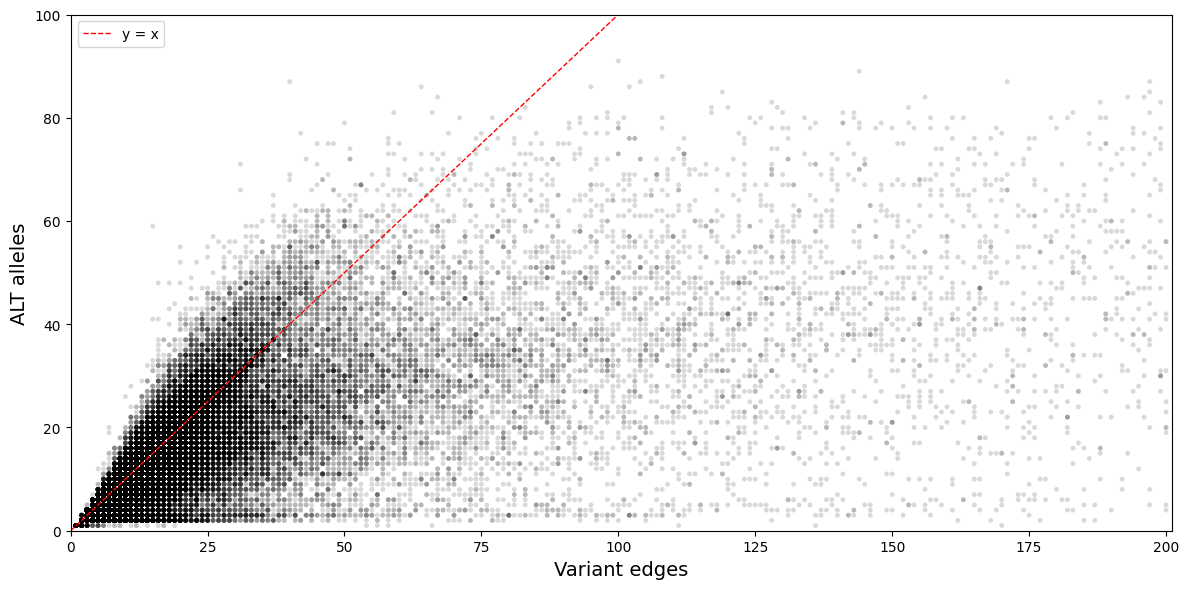

In [74]:
import matplotlib.pyplot as plt
import numpy as np

x = level0_df['num_variants'].to_numpy().astype(int)
y = level0_df['raw_vcf_allele_count'].to_numpy().astype(int)

# Set equal axis limits
min_range = 0
max_range = 100
# min_range = 0
# max_range = min(x.max(), y.max())

sample_index = (x >= min_range) & (x <= 2*max_range) & (y >= min_range) & (y <= max_range)
x = x[sample_index]
y = y[sample_index]

# Scatter plot
plt.figure(figsize=(12, 6))  # Set figure size
plt.scatter(x, y, color="black", marker='.', edgecolors='none', s=50, alpha=0.15)

plt.xlim(min_range, 2.01*max_range)
plt.ylim(min_range, max_range)

# Add y = x line
plt.plot([min_range, max_range], [min_range, max_range], color="red", linestyle="--", linewidth=1, label="y = x")

# Add labels, title, and legend
# plt.title("Scatter plot for bubbles", fontsize=16, pad=20)
plt.xlabel("Variant edges", fontsize=14)
plt.ylabel("ALT alleles", fontsize=14)

# Add grid for better visualization
plt.grid(False)
plt.legend(loc="upper left")

# Show plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/scatter_num_var_num_allele_bubble_density_all_chr.pdf', dpi=600)
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/scatter_num_var_num_allele_bubble_density_all_chr.png', dpi=600)

plt.show()


Histogram: motif length

In [2]:
graph_obj_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Graph_objs'
raw_vcf_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_chr'
graph_vcf_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/'

gfa_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data/chromosome_gfa'
snarl_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data/chr_snarls'
bubble_summary_dir = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Bubble_summary"
bubble_result_dir = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Bubble_result_update"

mode = 'AT'
wavevcf = True

In [3]:
motif_len_list = []

for i in tqdm(range(1,23)):
    graph_vcf_path = f"{graph_vcf_dir}/graph_chr{i}_no_terminus.vcf"
    graph_vcf_df = read_vcf_to_dataframe(graph_vcf_path)
    for k in range(len(graph_vcf_df)):
        row = graph_vcf_df.iloc[k]
        info = row['INFO']
        info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in info.split(';') if '=' in attr}
        motif = info_dict['TR_MOTIF']
        motif_len = 0 if motif == '.' else len(motif)

        motif_len_list.append(motif_len)

100%|██████████| 22/22 [40:43<00:00, 111.09s/it] 


In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
data = np.array(motif_len_list)  # Generate some data between 0 and 60

# Define custom bins
bins = list(range(1, 11)) + [20, 30, 40, 50] + [float('inf')]

# Adjust labels for each bin
bin_labels = [f"{i}" for i in range(1, 10)] + ["10-20", "20-30", "30-40", "40-50", "50+"]

# Compute histogram
counts, bin_edges = np.histogram(data, bins=bins)

# Create bar positions
bar_positions = np.arange(len(counts))

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(bar_positions, counts, edgecolor="black", alpha=1, color="#C5C9C7")

# Add custom x-axis labels
plt.xticks(bar_positions, bin_labels, fontsize=10)

# Add titles and labels
# plt.title("Histogram for bubbles", fontsize=16)
plt.xlabel("Length of motif", fontsize=14)
#plt.ylabel("Frequency", fontsize=14)

ax = plt.gca()  # Get the current axes
ax.set_yticklabels([])

y_bias = 0.01 * max(counts)

# Annotate bar counts
for i, count in enumerate(counts):
    plt.text(i, count + y_bias, str(count), ha="center", fontsize=10)

# Show plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/histogram_length_motif_all_chr.pdf', dpi=600, bbox_inches='tight', format='pdf')
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/histogram_length_motif_all_chr.png', dpi=600, bbox_inches='tight', format='png')

plt.show()

NameError: name 'motif_len_list' is not defined

Triallelic bubbles

           Bubble_type   Count
2  properly_triallelic   86889
0          overlapping  330245
3               nested   30596
1         interlocking  325761


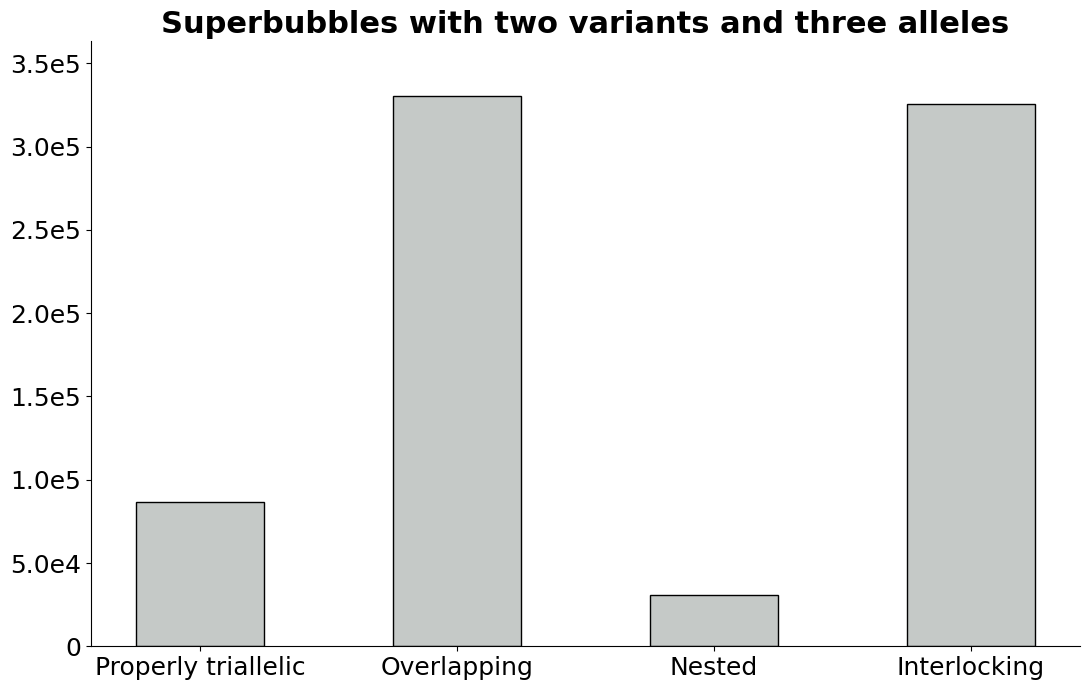

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Initialize a defaultdict to count bubble types across files
bubble_type_counts = defaultdict(int)

# Assuming all files are in a directory, you can use glob to get the file paths
file_dir = bubble_summary_dir

# Iterate over each file
for i in range(1,23):
    # Read the file into a DataFrame
    file_path = f"{file_dir}/bubble_triallelic_chr{i}.tsv"
    df = pd.read_csv(file_path, sep='\t')  # Assuming tab-separated values, adjust if necessary
    
    # Count the occurrences of each Bubble_type
    bubble_type_count = df['Bubble_type'].value_counts()
    
    # Update the overall bubble type count
    for bubble_type, count in bubble_type_count.items():
        if bubble_type not in {'overlapping', 'interlocking', 'nested', 'properly_triallelic'}:
            continue
        bubble_type_counts[bubble_type] += count

# Convert the defaultdict to a pandas DataFrame for plotting
bubble_type_df = pd.DataFrame(list(bubble_type_counts.items()), columns=['Bubble_type', 'Count'])

#
custom_order = ["properly_triallelic", "overlapping", "nested", "interlocking"]

# Convert "Bubble_type" to categorical with the custom order
bubble_type_df["Bubble_type"] = pd.Categorical(
    bubble_type_df["Bubble_type"], 
    categories=custom_order, 
    ordered=True
)

# Sort the dataframe based on this order
bubble_type_df = bubble_type_df.sort_values("Bubble_type")
print(bubble_type_df)

# Set a modern style for the plot
# sns.set(style="whitegrid", palette="muted")

# Extract x labels and y values
x_labels = ["Properly triallelic", "Overlapping", "Nested", "Interlocking"]
y_values = bubble_type_df["Count"].values

# Create figure
fig, ax = plt.subplots(figsize=(11, 7))

# Create bar plot (Pure Matplotlib)
ax.bar(x_labels, y_values, color="#C5C9C7", edgecolor="black", width=0.5)

# Enhance title and labels
ax.set_title("Superbubbles with two variants and three alleles", fontsize=22, weight="bold")
ax.set_xlabel("")
ax.set_ylabel("")
#ax.set_yticklabels([])

# Rotate x-axis labels for better readability
# Add custom x-axis labels
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(top=max(y_values)*1.1)

# Define scientific notation formatter
def scientific_notation_flexible(value, pos):
    if value == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(value))))
    base = value / 10**exponent
    return f"{base:.1f}e{exponent}"

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(scientific_notation_flexible))

# Remove top and right spines for a cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)

counts = bubble_type_df['Count']
y_bias = 0.01 * max(counts)

# Annotate bar counts
# for i, count in enumerate(counts):
#     plt.text(i, count + y_bias, str(count), ha="center", fontsize=10)

# Adjust layout to fit everything neatly
plt.tight_layout()


# Remove top and right spines for a cleaner look
# sns.despine()

# Save the figure as a high-resolution PNG or PDF for use in a paper
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/triallelic_super_bubble_summary.png', dpi=600, format='png')  # Use 'pdf' for vectorized format

# Show the plot
plt.show()

In [28]:
bubble_type_df['Proportion'] = bubble_type_df['Count']/bubble_type_df['Count'].sum()
print(bubble_type_df)

           Bubble_type   Count  Proportion
2  properly_triallelic   86889    0.112334
0          overlapping  330245    0.426954
3               nested   30596    0.039556
1         interlocking  325761    0.421157


Assemble Figure 3

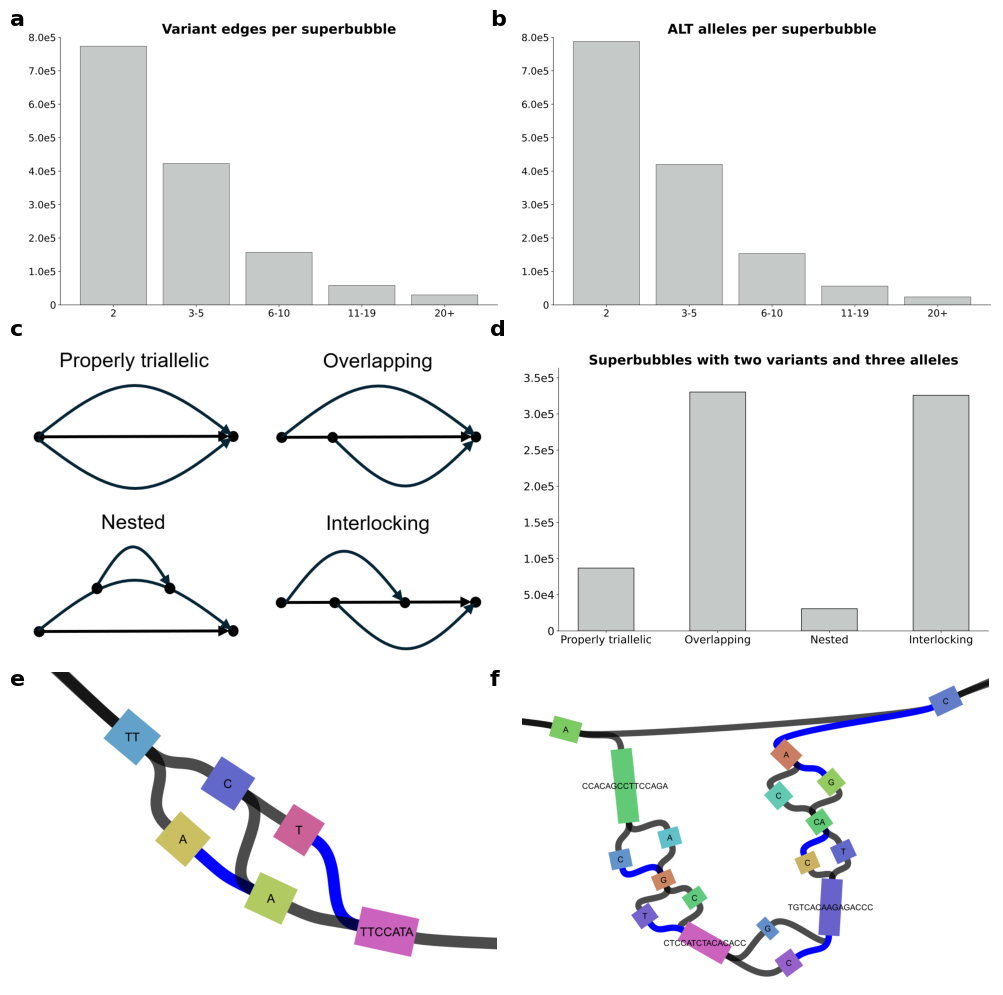

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

# Load images
img1 = mpimg.imread("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/histogram_num_vars_all_chr.png")
img2 = mpimg.imread("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/histogram_num_alleles_all_chr.png")
img3 = mpimg.imread("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/schematic_triallelic.png")
img4 = mpimg.imread("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/triallelic_super_bubble_summary.png")
img5 = mpimg.imread("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/triallelic_example1.png")
img6 = mpimg.imread("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/multiallelic_example2.png")

# Create figure and define a flexible grid layout
fig = plt.figure(figsize=(10, 10))  # Define overall figure size
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1])  

# First three charts in the first column (one per row)
ax1 = fig.add_subplot(gs[0, 0])  # Row 1, Col 1
ax2 = fig.add_subplot(gs[0, 1])  # Row 2, Col 1
ax3 = fig.add_subplot(gs[1, 0])

# Make Chart 4 and Chart 5 evenly share the second column
ax4 = fig.add_subplot(gs[1, 1])  # Chart 4 takes Row 1
ax5 = fig.add_subplot(gs[2, 0])  # Chart 5 takes Row 2 & 3
ax6 = fig.add_subplot(gs[2, 1])

# Display images
ax1.imshow(img1)
ax2.imshow(img2)
ax3.imshow(img3)
ax4.imshow(img4)
ax5.imshow(img5)
ax6.imshow(img6)

# Remove axis labels and ticks for a clean layout
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.axis("off")

# Define label positions to match the adjusted layout
label_positions = [(0.001, 0.99),
                   (0.481, 0.99),
                   (0.001, 0.68),
                   (0.481, 0.68),
                   (0.001, 0.33),
                   (0.481, 0.33)]

labels = ["a", "b", "c", "d", "e", "f"]

# Add global labels to the whole figure
for (x, y), label in zip(label_positions, labels):
    fig.text(x, y, label, fontsize=16, fontweight="bold", va="top", ha="left", color="black")

# Adjust layout and save the final figure
plt.tight_layout()
plt.savefig("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/assembled_figure3.pdf", bbox_inches="tight", dpi=600)
plt.savefig("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/assembled_figure3.png", bbox_inches="tight", dpi=600)

# Show the final image
plt.show()


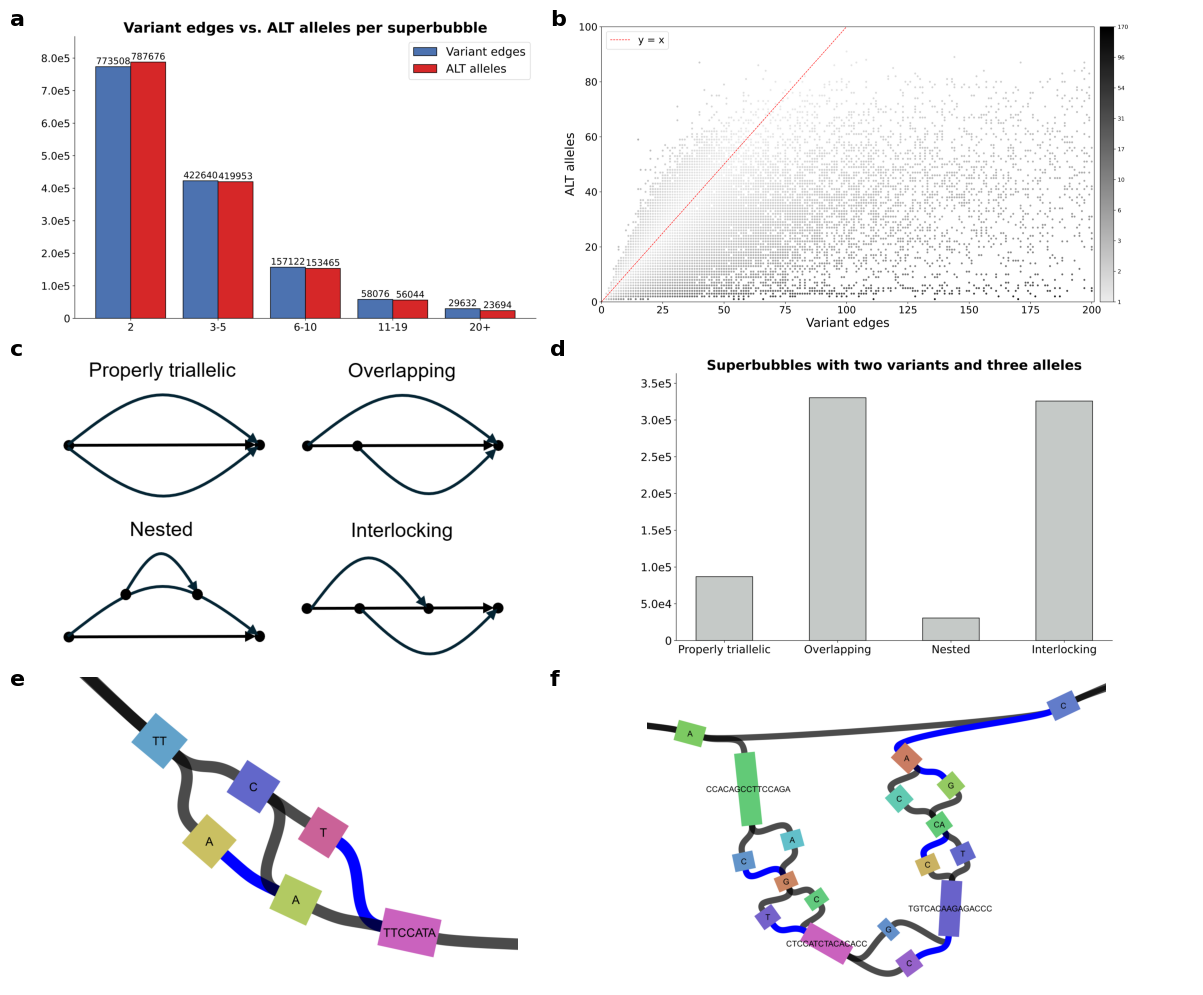

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

# Load images
img1 = mpimg.imread("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/grouped_histogram_num_variants_vs_num_alleles.png")
img2 = mpimg.imread("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/scatter_num_var_num_allele_ratio_intensity_all_chr.png")
img3 = mpimg.imread("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/schematic_triallelic.png")
img4 = mpimg.imread("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/triallelic_super_bubble_summary.png")
img5 = mpimg.imread("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/triallelic_example1.png")
img6 = mpimg.imread("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/multiallelic_example2.png")

# Create figure and define a flexible grid layout
fig = plt.figure(figsize=(12, 10))  # Define overall figure size
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1.2], height_ratios=[1.05, 1, 1])  

# First three charts in the first column (one per row)
ax1 = fig.add_subplot(gs[0, 0])  # Row 1, Col 1
ax2 = fig.add_subplot(gs[0, 1])  # Row 2, Col 1
ax3 = fig.add_subplot(gs[1, 0])

# Make Chart 4 and Chart 5 evenly share the second column
ax4 = fig.add_subplot(gs[1, 1])  # Chart 4 takes Row 1
ax5 = fig.add_subplot(gs[2, 0])  # Chart 5 takes Row 2 & 3
ax6 = fig.add_subplot(gs[2, 1])

# Display images
ax1.imshow(img1)
ax2.imshow(img2)
ax3.imshow(img3)
ax4.imshow(img4)
ax5.imshow(img5)
ax6.imshow(img6)

# Remove axis labels and ticks for a clean layout
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.axis("off")

# Define label positions to match the adjusted layout
label_positions = [(0.001, 0.99),
                   (0.451, 0.99),
                   (0.001, 0.66),
                   (0.451, 0.66),
                   (0.001, 0.33),
                   (0.451, 0.33)]

labels = ["a", "b", "c", "d", "e", "f"]

# Add global labels to the whole figure
for (x, y), label in zip(label_positions, labels):
    fig.text(x, y, label, fontsize=16, fontweight="bold", va="top", ha="left", color="black")

# Adjust layout and save the final figure
plt.tight_layout()
plt.savefig("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/assembled_figure3_v2.pdf", bbox_inches="tight", dpi=600)
plt.savefig("/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/assembled_figure3_v2.png", bbox_inches="tight", dpi=600)

# Show the final image
plt.show()
